# Ноутбук для предсказания временной последовательности (дебита нефти за 17 лет) при помощи рекуррентной нейронной сети GRU 

In [15]:
import sys
sys.path.append("../..") 
import math

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import random 
import tensorflow.keras as keras

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from tqdm import tqdm, tqdm_notebook, trange

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dropout, Dense, GRU
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.callbacks import ModelCheckpoint

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from typing import List
from typing import Tuple
from typing import Union

# Для корректного теста работы сети необходимо задать "random seed"

In [16]:
random.seed(5)
tf.random.set_seed(5)

# Определяем метрики, с помощью которых будем оценивать результаты работы сети

In [17]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true).squeeze(), np.array(y_pred).squeeze()
    y_m = [y_true != 0]
    return np.mean(np.abs((y_true[y_m] - y_pred[y_m]) / y_true[y_m])) * 100

def median_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true).squeeze(), np.array(y_pred).squeeze()
    y_m = [y_true != 0]
    return np.median(np.abs((y_true[y_m] - y_pred[y_m]) / y_true[y_m])) * 100

def metrics_sum(y_true,y_predicted):
    R2_sum = r2_score(y_true.sum(axis=1), y_predicted.sum(axis=1))
    MAE_sum = mean_absolute_error(y_true.sum(axis=1), y_predicted.sum(axis=1))
    MSE_sum = mean_squared_error(y_true.sum(axis=1), y_predicted.sum(axis=1))   
    MAPE_sum = mean_absolute_percentage_error(y_true.sum(axis=1), y_predicted.sum(axis=1))
    MMAPE_sum = median_mape(y_true.sum(axis=1), y_predicted.sum(axis=1))
    return R2_sum, MAE_sum, MSE_sum, MAPE_sum, MMAPE_sum

def metrics_pw(
        y_true: Union[np.array, pd.DataFrame],
        y_predicted: Union[np.array, pd.DataFrame]
):
    r2_pw = []
    mae_pw = []
    mse_pw = []
    mape_pw = []
    mmape_pw = []
    for i, j in zip(y_true.iterrows(), y_predicted):
        r2_pw.append(r2_score(i[1], j))
        mae_pw.append(mean_absolute_error(i[1], j))
        mse_pw.append(mean_squared_error(i[1], j))
        mask = [i[1] != 0]
        mape = np.mean(np.abs((i[1][mask[0].values] - j[mask]) / i[1][mask[0].values])) * 100
        if math.isnan(mape):
            continue
        mape_pw.append(mape)
        mmape = np.median(np.abs((i[1][mask[0].values] - j[mask]) / i[1][mask[0].values])) * 100
        mmape_pw.append(mmape)
    return np.array(r2_pw).mean(), np.array(mae_pw).mean(), np.array(mse_pw).mean(), np.array(mape_pw).mean(), np.array(mmape_pw).mean()


# Загружаем данные 

In [18]:
path_to_params = Path('../datasets/seq/water')
debs = Path(path_to_params).glob('*debits.csv')
deb = pd.DataFrame()
params = Path(path_to_params).glob('*batch.csv')
param = pd.DataFrame()
for i in params:
    tmp = pd.read_csv(i,index_col=0)
    param = pd.concat([param, tmp], ignore_index=True)
    print(f'Loaded data: {i}')
for i in debs:
    tmp = pd.read_csv(i,index_col=0)
    deb = pd.concat([deb, tmp], ignore_index=True)
    print(f'Loaded data: {i}')


Loaded data: ..\datasets\seq\water\batch_1_0-99_wo_In_batch.csv
Loaded data: ..\datasets\seq\water\batch_1_100-199_wo_In_batch.csv
Loaded data: ..\datasets\seq\water\batch_1_200-499_wo_In_batch.csv
Loaded data: ..\datasets\seq\water\batch_1_500-999_wo_In_batch.csv
Loaded data: ..\datasets\seq\water\batch_2_wo_In_batch.csv
Loaded data: ..\datasets\seq\water\batch_3_wo_In_batch.csv
Loaded data: ..\datasets\seq\water\batch_4_wo_In_batch.csv
Loaded data: ..\datasets\seq\water\batch_1_0-99_wo_debits.csv
Loaded data: ..\datasets\seq\water\batch_1_100-199_wo_debits.csv
Loaded data: ..\datasets\seq\water\batch_1_200-499_wo_debits.csv
Loaded data: ..\datasets\seq\water\batch_1_500-999_wo_debits.csv
Loaded data: ..\datasets\seq\water\batch_2_wo_debits.csv
Loaded data: ..\datasets\seq\water\batch_3_wo_debits.csv
Loaded data: ..\datasets\seq\water\batch_4_wo_debits.csv


In [19]:
X = param
Y = deb
ind=len(X)

In [20]:
X

,SO,poro,VD,pres,Anisothropy,perm,inj_rate,SQ,temp,steam_temp,heatcr
0,0.84,0.20,8,31,0.60,200,317,0.79,99,271,2390
1,0.75,0.35,8,46,0.69,800,183,0.81,84,247,2408
2,0.74,0.15,16,54,0.97,800,170,0.52,49,278,2578
3,0.51,0.20,14,44,0.94,200,302,0.86,90,208,2680
4,0.67,0.15,4,46,0.11,800,300,0.71,90,228,2324
...,...,...,...,...,...,...,...,...,...,...,...
3281,0.87,0.15,13,62,0.29,150,165,0.87,74,237,2151
3282,0.84,0.20,15,64,0.68,900,241,0.74,101,268,2577
3283,0.63,0.40,12,62,0.39,600,310,0.71,69,191,2675
3284,0.65,0.15,10,51,0.51,900,211,0.51,108,243,2779


In [21]:
X.drop({'SQ','steam_temp'},axis=1,inplace=True)
X

,SO,poro,VD,pres,Anisothropy,perm,inj_rate,temp,heatcr
0,0.84,0.20,8,31,0.60,200,317,99,2390
1,0.75,0.35,8,46,0.69,800,183,84,2408
2,0.74,0.15,16,54,0.97,800,170,49,2578
3,0.51,0.20,14,44,0.94,200,302,90,2680
4,0.67,0.15,4,46,0.11,800,300,90,2324
...,...,...,...,...,...,...,...,...,...
3281,0.87,0.15,13,62,0.29,150,165,74,2151
3282,0.84,0.20,15,64,0.68,900,241,101,2577
3283,0.63,0.40,12,62,0.39,600,310,69,2675
3284,0.65,0.15,10,51,0.51,900,211,108,2779


In [22]:
Y

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,141.727678,83.129849,91.248891,115.220274,103.826376,95.958622,89.076483,81.293112,73.723770,67.244986,61.704541,56.828121,52.430149,48.574598,45.444909,43.025675,27.526870
1,130.433223,130.877083,108.439330,91.961432,81.602634,74.817328,68.526982,64.123907,60.719963,57.804083,55.029168,52.728943,50.981758,49.330275,47.779162,46.372534,30.176391
2,111.830706,66.287333,81.194689,79.964741,75.781038,72.501985,64.959030,60.217281,57.759762,53.344992,47.274737,41.560381,36.601066,32.636970,29.615280,27.368506,17.184848
3,99.610610,53.081568,33.711720,24.518512,19.167808,16.468650,14.131553,12.617986,11.460548,10.371196,9.501614,8.781269,8.203756,7.818520,7.517687,7.241965,4.677149
4,62.689597,52.365188,45.623790,40.291627,36.382129,33.136778,30.434036,28.047353,25.680443,23.836651,22.389672,21.185892,20.144441,19.151871,18.259415,17.430882,11.183410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3281,179.881095,80.847179,74.316832,69.070847,60.125494,52.771177,46.244483,41.096456,37.293379,34.099976,31.477765,29.624486,28.452932,27.876832,27.155381,26.464299,17.423776
3282,759.690384,352.300812,216.415234,146.436272,108.454314,89.906387,77.252374,69.036800,63.533200,60.104973,56.453145,52.886836,50.060597,47.841855,45.963460,44.211275,28.548038
3283,59.163501,55.135715,54.381975,52.521704,49.522587,46.081740,42.685926,39.064790,36.010256,33.557082,31.060140,28.862559,27.081769,25.590312,24.395229,23.368012,15.107969
3284,211.224380,93.130698,60.474397,47.785628,41.122073,36.528243,33.009604,30.218247,27.958599,25.951669,24.083923,22.388897,20.812562,19.414143,18.137536,16.924211,10.654631


# Задаем гиперпараметры сети

In [23]:
verbose = 2
epochs = 200
batch_size = 256
n_timesteps = Y.shape[1]
n_features = X.shape[1]
dropout_rate=0.2
#a_r=l1(0.001)

# Задаем саму сеть и обучаем её с 10-блочной кросс-валидацией

In [10]:
R2_sum = []
MAE_sum = []
MSE_sum = []
MAPE_sum = []
MMAPE_sum = []

R2_median_pw = []
MAE_mean_pw = []
MSE_mean_pw =[]
MAPE_mean_pw = []
MAPE_median_pw =[]

histories=[]

CV = KFold(10, random_state=5)
for train_ind, test_ind in tqdm(CV.split(X)): 
    train_x, test_x = X.iloc[train_ind], X.iloc[test_ind]
    train_y, test_y = Y.iloc[train_ind, :], Y.iloc[test_ind, :]

    scaler_X = MinMaxScaler()
    scaler_X.fit(np.array(train_x))
    
    scaler_y = np.mean(np.mean(train_y))
    
    train_x_transformed,train_y_transformed = scaler_X.transform(np.array(train_x)) , train_y / scaler_y
    test_x_transformed, test_y_transformed = scaler_X.transform(np.array(test_x)) , test_y / scaler_y

    model = Sequential()
    model.add(keras.layers.RepeatVector(n_timesteps, input_shape=(n_features,)))
    model.add(GRU(64,return_sequences=True))
    model.add(keras.layers.Dropout(dropout_rate))
    model.add(GRU(64,return_sequences=True))
    model.add(GRU(32,return_sequences=True))  
    model.add(keras.layers.Dense(1))

    checkpoint = ModelCheckpoint(f"SAGD_model_{ind}.hdf5", monitor='val_loss',save_best_only=True)
    opt = keras.optimizers.Adam(learning_rate=0.01)

    model.compile(optimizer=opt, loss='mae')
    history = model.fit(train_x_transformed, train_y_transformed, epochs=epochs, validation_split=0.2, 
                        verbose=2, batch_size=batch_size, callbacks = [checkpoint], shuffle = False
    )
    histories.append(history)
    
    best_model = keras.models.load_model(f"SAGD_model_{ind}.hdf5")
    
    predicted_y = best_model.predict(test_x_transformed)
    predicted_y = predicted_y.reshape(predicted_y.shape[:-1])
    predicted_y = predicted_y * scaler_y
    predicted_y[predicted_y < 0] = 0
    
    R2_median_pw_tmp, MAE_mean_pw_tmp, MSE_mean_pw_tmp, MAPE_mean_pw_tmp, MAPE_median_pw_tmp = metrics_pw(test_y, predicted_y)
    R2_sum_tmp , MAE_sum_tmp, MSE_sum_tmp, MAPE_sum_tmp, MMAPE_sum_tmp = metrics_sum(test_y, predicted_y)

    R2_sum.append(R2_sum_tmp)
    MAE_sum.append(MAE_sum_tmp)
    MSE_sum.append(MSE_sum_tmp)
    MAPE_sum.append(MAPE_sum_tmp)
    MMAPE_sum.append(MMAPE_sum_tmp)

    R2_median_pw.append(R2_median_pw_tmp)
    MAE_mean_pw.append(MAE_mean_pw_tmp)
    MSE_mean_pw.append(MSE_mean_pw_tmp)
    MAPE_mean_pw.append(MAPE_mean_pw_tmp)
    MAPE_median_pw.append(MAPE_median_pw_tmp)


0it [00:00, ?it/s]

Epoch 1/200
6/6 - 19s - loss: 0.8221 - val_loss: 0.6074
Epoch 2/200
6/6 - 2s - loss: 0.5770 - val_loss: 0.5443
Epoch 3/200
6/6 - 2s - loss: 0.5049 - val_loss: 0.5298
Epoch 4/200
6/6 - 2s - loss: 0.4544 - val_loss: 0.4477
Epoch 5/200
6/6 - 2s - loss: 0.4126 - val_loss: 0.4043
Epoch 6/200
6/6 - 2s - loss: 0.3708 - val_loss: 0.3601
Epoch 7/200
6/6 - 2s - loss: 0.3439 - val_loss: 0.3512
Epoch 8/200
6/6 - 2s - loss: 0.3251 - val_loss: 0.3334
Epoch 9/200
6/6 - 2s - loss: 0.3094 - val_loss: 0.3189
Epoch 10/200
6/6 - 2s - loss: 0.3023 - val_loss: 0.2918
Epoch 11/200
6/6 - 2s - loss: 0.2781 - val_loss: 0.2855
Epoch 12/200
6/6 - 2s - loss: 0.2672 - val_loss: 0.2781
Epoch 13/200
6/6 - 2s - loss: 0.2840 - val_loss: 0.2867
Epoch 14/200
6/6 - 2s - loss: 0.2635 - val_loss: 0.2591
Epoch 15/200
6/6 - 2s - loss: 0.2420 - val_loss: 0.2564
Epoch 16/200
6/6 - 2s - loss: 0.2370 - val_loss: 0.2424
Epoch 17/200
6/6 - 2s - loss: 0.2560 - val_loss: 0.2722
Epoch 18/200
6/6 - 2s - loss: 0.2479 - val_loss: 0.2701


Epoch 147/200
6/6 - 2s - loss: 0.0899 - val_loss: 0.1021
Epoch 148/200
6/6 - 2s - loss: 0.0884 - val_loss: 0.0916
Epoch 149/200
6/6 - 2s - loss: 0.0900 - val_loss: 0.0833
Epoch 150/200
6/6 - 2s - loss: 0.0892 - val_loss: 0.0840
Epoch 151/200
6/6 - 2s - loss: 0.0831 - val_loss: 0.0930
Epoch 152/200
6/6 - 2s - loss: 0.0841 - val_loss: 0.0859
Epoch 153/200
6/6 - 2s - loss: 0.0872 - val_loss: 0.0872
Epoch 154/200
6/6 - 2s - loss: 0.0818 - val_loss: 0.0924
Epoch 155/200
6/6 - 2s - loss: 0.0824 - val_loss: 0.0905
Epoch 156/200
6/6 - 2s - loss: 0.0907 - val_loss: 0.0935
Epoch 157/200
6/6 - 2s - loss: 0.0947 - val_loss: 0.0884
Epoch 158/200
6/6 - 2s - loss: 0.0861 - val_loss: 0.0873
Epoch 159/200
6/6 - 2s - loss: 0.0871 - val_loss: 0.1178
Epoch 160/200
6/6 - 2s - loss: 0.1067 - val_loss: 0.1046
Epoch 161/200
6/6 - 2s - loss: 0.0994 - val_loss: 0.1057
Epoch 162/200
6/6 - 2s - loss: 0.0940 - val_loss: 0.0931
Epoch 163/200
6/6 - 2s - loss: 0.0901 - val_loss: 0.0972
Epoch 164/200
6/6 - 2s - loss: 

1it [06:58, 418.24s/it]

Epoch 1/200
6/6 - 17s - loss: 0.9230 - val_loss: 0.6228
Epoch 2/200
6/6 - 2s - loss: 0.6044 - val_loss: 0.5832
Epoch 3/200
6/6 - 2s - loss: 0.5300 - val_loss: 0.5203
Epoch 4/200
6/6 - 2s - loss: 0.4632 - val_loss: 0.4259
Epoch 5/200
6/6 - 2s - loss: 0.4166 - val_loss: 0.3997
Epoch 6/200
6/6 - 2s - loss: 0.3835 - val_loss: 0.3834
Epoch 7/200
6/6 - 2s - loss: 0.3728 - val_loss: 0.3659
Epoch 8/200
6/6 - 2s - loss: 0.3575 - val_loss: 0.3321
Epoch 9/200
6/6 - 2s - loss: 0.3192 - val_loss: 0.3208
Epoch 10/200
6/6 - 2s - loss: 0.3156 - val_loss: 0.3159
Epoch 11/200
6/6 - 2s - loss: 0.2973 - val_loss: 0.2951
Epoch 12/200
6/6 - 2s - loss: 0.2907 - val_loss: 0.2908
Epoch 13/200
6/6 - 2s - loss: 0.2816 - val_loss: 0.2727
Epoch 14/200
6/6 - 2s - loss: 0.2684 - val_loss: 0.2601
Epoch 15/200
6/6 - 2s - loss: 0.2594 - val_loss: 0.2589
Epoch 16/200
6/6 - 2s - loss: 0.2546 - val_loss: 0.2514
Epoch 17/200
6/6 - 2s - loss: 0.2410 - val_loss: 0.2469
Epoch 18/200
6/6 - 2s - loss: 0.2341 - val_loss: 0.2576


Epoch 147/200
6/6 - 2s - loss: 0.0978 - val_loss: 0.1054
Epoch 148/200
6/6 - 2s - loss: 0.0964 - val_loss: 0.0894
Epoch 149/200
6/6 - 2s - loss: 0.0975 - val_loss: 0.0997
Epoch 150/200
6/6 - 2s - loss: 0.0918 - val_loss: 0.0911
Epoch 151/200
6/6 - 2s - loss: 0.0928 - val_loss: 0.0904
Epoch 152/200
6/6 - 2s - loss: 0.0942 - val_loss: 0.0900
Epoch 153/200
6/6 - 2s - loss: 0.0897 - val_loss: 0.1045
Epoch 154/200
6/6 - 2s - loss: 0.0910 - val_loss: 0.0882
Epoch 155/200
6/6 - 2s - loss: 0.0975 - val_loss: 0.0972
Epoch 156/200
6/6 - 2s - loss: 0.1038 - val_loss: 0.1822
Epoch 157/200
6/6 - 2s - loss: 0.1332 - val_loss: 0.1028
Epoch 158/200
6/6 - 2s - loss: 0.1048 - val_loss: 0.1422
Epoch 159/200
6/6 - 2s - loss: 0.1279 - val_loss: 0.1220
Epoch 160/200
6/6 - 2s - loss: 0.1031 - val_loss: 0.0908
Epoch 161/200
6/6 - 2s - loss: 0.1079 - val_loss: 0.1188
Epoch 162/200
6/6 - 2s - loss: 0.0953 - val_loss: 0.0867
Epoch 163/200
6/6 - 2s - loss: 0.0960 - val_loss: 0.0886
Epoch 164/200
6/6 - 2s - loss: 

2it [13:54, 417.66s/it]

Epoch 1/200
6/6 - 18s - loss: 0.8757 - val_loss: 0.6408
Epoch 2/200
6/6 - 2s - loss: 0.5854 - val_loss: 0.5375
Epoch 3/200
6/6 - 2s - loss: 0.4934 - val_loss: 0.5601
Epoch 4/200
6/6 - 2s - loss: 0.4617 - val_loss: 0.4328
Epoch 5/200
6/6 - 2s - loss: 0.4090 - val_loss: 0.4157
Epoch 6/200
6/6 - 2s - loss: 0.3754 - val_loss: 0.3661
Epoch 7/200
6/6 - 2s - loss: 0.3560 - val_loss: 0.3622
Epoch 8/200
6/6 - 2s - loss: 0.3423 - val_loss: 0.3462
Epoch 9/200
6/6 - 2s - loss: 0.3379 - val_loss: 0.3340
Epoch 10/200
6/6 - 2s - loss: 0.3255 - val_loss: 0.3109
Epoch 11/200
6/6 - 2s - loss: 0.3056 - val_loss: 0.2962
Epoch 12/200
6/6 - 2s - loss: 0.2915 - val_loss: 0.2988
Epoch 13/200
6/6 - 2s - loss: 0.2768 - val_loss: 0.2738
Epoch 14/200
6/6 - 2s - loss: 0.2723 - val_loss: 0.2733
Epoch 15/200
6/6 - 2s - loss: 0.2684 - val_loss: 0.2632
Epoch 16/200
6/6 - 2s - loss: 0.2589 - val_loss: 0.2513
Epoch 17/200
6/6 - 2s - loss: 0.2528 - val_loss: 0.2443
Epoch 18/200
6/6 - 2s - loss: 0.2435 - val_loss: 0.2645


Epoch 147/200
6/6 - 2s - loss: 0.1125 - val_loss: 0.1221
Epoch 148/200
6/6 - 2s - loss: 0.1075 - val_loss: 0.1411
Epoch 149/200
6/6 - 2s - loss: 0.1090 - val_loss: 0.1123
Epoch 150/200
6/6 - 2s - loss: 0.1107 - val_loss: 0.1548
Epoch 151/200
6/6 - 2s - loss: 0.1029 - val_loss: 0.1051
Epoch 152/200
6/6 - 2s - loss: 0.1026 - val_loss: 0.1308
Epoch 153/200
6/6 - 2s - loss: 0.0965 - val_loss: 0.1158
Epoch 154/200
6/6 - 2s - loss: 0.1037 - val_loss: 0.1515
Epoch 155/200
6/6 - 2s - loss: 0.1116 - val_loss: 0.1163
Epoch 156/200
6/6 - 2s - loss: 0.1065 - val_loss: 0.1176
Epoch 157/200
6/6 - 2s - loss: 0.0993 - val_loss: 0.1562
Epoch 158/200
6/6 - 2s - loss: 0.1135 - val_loss: 0.1444
Epoch 159/200
6/6 - 2s - loss: 0.1109 - val_loss: 0.1353
Epoch 160/200
6/6 - 2s - loss: 0.1018 - val_loss: 0.1139
Epoch 161/200
6/6 - 2s - loss: 0.0935 - val_loss: 0.1522
Epoch 162/200
6/6 - 2s - loss: 0.0989 - val_loss: 0.1272
Epoch 163/200
6/6 - 2s - loss: 0.1030 - val_loss: 0.1603
Epoch 164/200
6/6 - 2s - loss: 

3it [20:41, 414.37s/it]

Epoch 1/200
6/6 - 19s - loss: 0.8648 - val_loss: 0.6245
Epoch 2/200
6/6 - 2s - loss: 0.5806 - val_loss: 0.5396
Epoch 3/200
6/6 - 2s - loss: 0.4981 - val_loss: 0.4683
Epoch 4/200
6/6 - 2s - loss: 0.4401 - val_loss: 0.4156
Epoch 5/200
6/6 - 2s - loss: 0.3982 - val_loss: 0.3798
Epoch 6/200
6/6 - 2s - loss: 0.3645 - val_loss: 0.3666
Epoch 7/200
6/6 - 2s - loss: 0.3481 - val_loss: 0.3748
Epoch 8/200
6/6 - 2s - loss: 0.3683 - val_loss: 0.4138
Epoch 9/200
6/6 - 2s - loss: 0.3445 - val_loss: 0.3330
Epoch 10/200
6/6 - 2s - loss: 0.3202 - val_loss: 0.3436
Epoch 11/200
6/6 - 2s - loss: 0.3051 - val_loss: 0.2949
Epoch 12/200
6/6 - 2s - loss: 0.2931 - val_loss: 0.2895
Epoch 13/200
6/6 - 2s - loss: 0.2749 - val_loss: 0.2862
Epoch 14/200
6/6 - 2s - loss: 0.2651 - val_loss: 0.2648
Epoch 15/200
6/6 - 2s - loss: 0.2563 - val_loss: 0.2571
Epoch 16/200
6/6 - 2s - loss: 0.2597 - val_loss: 0.2543
Epoch 17/200
6/6 - 2s - loss: 0.2458 - val_loss: 0.2430
Epoch 18/200
6/6 - 2s - loss: 0.2359 - val_loss: 0.2356


Epoch 147/200
6/6 - 2s - loss: 0.1131 - val_loss: 0.1274
Epoch 148/200
6/6 - 2s - loss: 0.1067 - val_loss: 0.1224
Epoch 149/200
6/6 - 2s - loss: 0.1062 - val_loss: 0.1154
Epoch 150/200
6/6 - 2s - loss: 0.0984 - val_loss: 0.1625
Epoch 151/200
6/6 - 2s - loss: 0.1078 - val_loss: 0.1281
Epoch 152/200
6/6 - 2s - loss: 0.0991 - val_loss: 0.1228
Epoch 153/200
6/6 - 2s - loss: 0.0964 - val_loss: 0.1232
Epoch 154/200
6/6 - 2s - loss: 0.0940 - val_loss: 0.1204
Epoch 155/200
6/6 - 2s - loss: 0.0968 - val_loss: 0.1119
Epoch 156/200
6/6 - 2s - loss: 0.0938 - val_loss: 0.1137
Epoch 157/200
6/6 - 2s - loss: 0.0995 - val_loss: 0.1465
Epoch 158/200
6/6 - 2s - loss: 0.1013 - val_loss: 0.1104
Epoch 159/200
6/6 - 2s - loss: 0.0982 - val_loss: 0.1427
Epoch 160/200
6/6 - 2s - loss: 0.0978 - val_loss: 0.1491
Epoch 161/200
6/6 - 2s - loss: 0.1006 - val_loss: 0.1091
Epoch 162/200
6/6 - 2s - loss: 0.0975 - val_loss: 0.1235
Epoch 163/200
6/6 - 2s - loss: 0.0979 - val_loss: 0.1166
Epoch 164/200
6/6 - 2s - loss: 

4it [27:24, 410.96s/it]

Epoch 1/200
6/6 - 15s - loss: 0.8877 - val_loss: 0.6372
Epoch 2/200
6/6 - 2s - loss: 0.5892 - val_loss: 0.5527
Epoch 3/200
6/6 - 2s - loss: 0.5026 - val_loss: 0.5106
Epoch 4/200
6/6 - 2s - loss: 0.4607 - val_loss: 0.4307
Epoch 5/200
6/6 - 2s - loss: 0.4100 - val_loss: 0.4245
Epoch 6/200
6/6 - 2s - loss: 0.4035 - val_loss: 0.3884
Epoch 7/200
6/6 - 2s - loss: 0.3715 - val_loss: 0.3601
Epoch 8/200
6/6 - 2s - loss: 0.3554 - val_loss: 0.3480
Epoch 9/200
6/6 - 2s - loss: 0.3298 - val_loss: 0.3264
Epoch 10/200
6/6 - 2s - loss: 0.3237 - val_loss: 0.3151
Epoch 11/200
6/6 - 2s - loss: 0.3078 - val_loss: 0.3119
Epoch 12/200
6/6 - 2s - loss: 0.2940 - val_loss: 0.2912
Epoch 13/200
6/6 - 2s - loss: 0.2790 - val_loss: 0.2804
Epoch 14/200
6/6 - 2s - loss: 0.2695 - val_loss: 0.2819
Epoch 15/200
6/6 - 2s - loss: 0.2839 - val_loss: 0.2612
Epoch 16/200
6/6 - 2s - loss: 0.2828 - val_loss: 0.2849
Epoch 17/200
6/6 - 2s - loss: 0.2846 - val_loss: 0.3024
Epoch 18/200
6/6 - 2s - loss: 0.2558 - val_loss: 0.2556


Epoch 147/200
6/6 - 2s - loss: 0.0941 - val_loss: 0.1049
Epoch 148/200
6/6 - 2s - loss: 0.0944 - val_loss: 0.1024
Epoch 149/200
6/6 - 2s - loss: 0.0951 - val_loss: 0.1096
Epoch 150/200
6/6 - 2s - loss: 0.0900 - val_loss: 0.0902
Epoch 151/200
6/6 - 2s - loss: 0.0972 - val_loss: 0.0974
Epoch 152/200
6/6 - 2s - loss: 0.0921 - val_loss: 0.1228
Epoch 153/200
6/6 - 2s - loss: 0.0898 - val_loss: 0.1005
Epoch 154/200
6/6 - 2s - loss: 0.0983 - val_loss: 0.0997
Epoch 155/200
6/6 - 2s - loss: 0.0985 - val_loss: 0.1374
Epoch 156/200
6/6 - 2s - loss: 0.1005 - val_loss: 0.1289
Epoch 157/200
6/6 - 2s - loss: 0.0950 - val_loss: 0.0960
Epoch 158/200
6/6 - 2s - loss: 0.0985 - val_loss: 0.1108
Epoch 159/200
6/6 - 2s - loss: 0.0977 - val_loss: 0.1224
Epoch 160/200
6/6 - 2s - loss: 0.0966 - val_loss: 0.1462
Epoch 161/200
6/6 - 2s - loss: 0.1002 - val_loss: 0.1140
Epoch 162/200
6/6 - 2s - loss: 0.1001 - val_loss: 0.1166
Epoch 163/200
6/6 - 2s - loss: 0.1042 - val_loss: 0.1354
Epoch 164/200
6/6 - 2s - loss: 

5it [3:19:35, 3387.04s/it]

Epoch 1/200
6/6 - 18s - loss: 0.9414 - val_loss: 0.6481
Epoch 2/200
6/6 - 2s - loss: 0.6031 - val_loss: 0.5586
Epoch 3/200
6/6 - 2s - loss: 0.5238 - val_loss: 0.4988
Epoch 4/200
6/6 - 2s - loss: 0.4861 - val_loss: 0.4714
Epoch 5/200
6/6 - 2s - loss: 0.4410 - val_loss: 0.4350
Epoch 6/200
6/6 - 2s - loss: 0.4141 - val_loss: 0.3926
Epoch 7/200
6/6 - 2s - loss: 0.3699 - val_loss: 0.3708
Epoch 8/200
6/6 - 2s - loss: 0.3566 - val_loss: 0.3487
Epoch 9/200
6/6 - 2s - loss: 0.3313 - val_loss: 0.3320
Epoch 10/200
6/6 - 2s - loss: 0.3167 - val_loss: 0.3219
Epoch 11/200
6/6 - 2s - loss: 0.3064 - val_loss: 0.3234
Epoch 12/200
6/6 - 2s - loss: 0.3101 - val_loss: 0.3166
Epoch 13/200
6/6 - 2s - loss: 0.3107 - val_loss: 0.3103
Epoch 14/200
6/6 - 2s - loss: 0.2952 - val_loss: 0.2823
Epoch 15/200
6/6 - 2s - loss: 0.2759 - val_loss: 0.2791
Epoch 16/200
6/6 - 3s - loss: 0.2659 - val_loss: 0.2766
Epoch 17/200
6/6 - 2s - loss: 0.2595 - val_loss: 0.2620
Epoch 18/200
6/6 - 2s - loss: 0.2443 - val_loss: 0.2445


Epoch 147/200
6/6 - 2s - loss: 0.1149 - val_loss: 0.1352
Epoch 148/200
6/6 - 2s - loss: 0.1131 - val_loss: 0.1305
Epoch 149/200
6/6 - 2s - loss: 0.1067 - val_loss: 0.1293
Epoch 150/200
6/6 - 2s - loss: 0.0968 - val_loss: 0.1331
Epoch 151/200
6/6 - 2s - loss: 0.0973 - val_loss: 0.1221
Epoch 152/200
6/6 - 2s - loss: 0.1032 - val_loss: 0.1364
Epoch 153/200
6/6 - 2s - loss: 0.1081 - val_loss: 0.1183
Epoch 154/200
6/6 - 2s - loss: 0.1056 - val_loss: 0.1352
Epoch 155/200
6/6 - 2s - loss: 0.1125 - val_loss: 0.1544
Epoch 156/200
6/6 - 2s - loss: 0.1111 - val_loss: 0.1381
Epoch 157/200
6/6 - 2s - loss: 0.1162 - val_loss: 0.1669
Epoch 158/200
6/6 - 2s - loss: 0.1248 - val_loss: 0.1815
Epoch 159/200
6/6 - 2s - loss: 0.1143 - val_loss: 0.1225
Epoch 160/200
6/6 - 2s - loss: 0.1098 - val_loss: 0.1605
Epoch 161/200
6/6 - 2s - loss: 0.1232 - val_loss: 0.1878
Epoch 162/200
6/6 - 2s - loss: 0.1263 - val_loss: 0.1553
Epoch 163/200
6/6 - 2s - loss: 0.1035 - val_loss: 0.1301
Epoch 164/200
6/6 - 2s - loss: 

6it [3:26:36, 2497.33s/it]

Epoch 1/200
6/6 - 15s - loss: 0.9222 - val_loss: 0.6315
Epoch 2/200
6/6 - 2s - loss: 0.5985 - val_loss: 0.5460
Epoch 3/200
6/6 - 2s - loss: 0.5167 - val_loss: 0.5652
Epoch 4/200
6/6 - 2s - loss: 0.4949 - val_loss: 0.4768
Epoch 5/200
6/6 - 2s - loss: 0.4344 - val_loss: 0.4300
Epoch 6/200
6/6 - 2s - loss: 0.4076 - val_loss: 0.4373
Epoch 7/200
6/6 - 2s - loss: 0.4011 - val_loss: 0.3661
Epoch 8/200
6/6 - 2s - loss: 0.3691 - val_loss: 0.3462
Epoch 9/200
6/6 - 2s - loss: 0.3369 - val_loss: 0.3306
Epoch 10/200
6/6 - 2s - loss: 0.3257 - val_loss: 0.3207
Epoch 11/200
6/6 - 2s - loss: 0.3129 - val_loss: 0.3238
Epoch 12/200
6/6 - 2s - loss: 0.3003 - val_loss: 0.2988
Epoch 13/200
6/6 - 2s - loss: 0.2969 - val_loss: 0.3045
Epoch 14/200
6/6 - 2s - loss: 0.2925 - val_loss: 0.2770
Epoch 15/200
6/6 - 2s - loss: 0.2728 - val_loss: 0.2796
Epoch 16/200
6/6 - 2s - loss: 0.2593 - val_loss: 0.2643
Epoch 17/200
6/6 - 2s - loss: 0.2630 - val_loss: 0.2885
Epoch 18/200
6/6 - 2s - loss: 0.2797 - val_loss: 0.3132


Epoch 147/200
6/6 - 2s - loss: 0.0988 - val_loss: 0.1437
Epoch 148/200
6/6 - 2s - loss: 0.1045 - val_loss: 0.0878
Epoch 149/200
6/6 - 2s - loss: 0.1180 - val_loss: 0.1777
Epoch 150/200
6/6 - 2s - loss: 0.1102 - val_loss: 0.1031
Epoch 151/200
6/6 - 2s - loss: 0.1074 - val_loss: 0.1630
Epoch 152/200
6/6 - 2s - loss: 0.1061 - val_loss: 0.0952
Epoch 153/200
6/6 - 2s - loss: 0.1005 - val_loss: 0.1476
Epoch 154/200
6/6 - 2s - loss: 0.1052 - val_loss: 0.1082
Epoch 155/200
6/6 - 2s - loss: 0.0959 - val_loss: 0.1109
Epoch 156/200
6/6 - 2s - loss: 0.1042 - val_loss: 0.1429
Epoch 157/200
6/6 - 2s - loss: 0.0990 - val_loss: 0.0928
Epoch 158/200
6/6 - 2s - loss: 0.0964 - val_loss: 0.1349
Epoch 159/200
6/6 - 2s - loss: 0.0918 - val_loss: 0.1200
Epoch 160/200
6/6 - 3s - loss: 0.0953 - val_loss: 0.1202
Epoch 161/200
6/6 - 3s - loss: 0.0962 - val_loss: 0.1219
Epoch 162/200
6/6 - 2s - loss: 0.0924 - val_loss: 0.0929
Epoch 163/200
6/6 - 2s - loss: 0.0975 - val_loss: 0.1177
Epoch 164/200
6/6 - 3s - loss: 

7it [3:33:42, 1875.94s/it]

Epoch 1/200
6/6 - 22s - loss: 0.8875 - val_loss: 0.6070
Epoch 2/200
6/6 - 2s - loss: 0.6008 - val_loss: 0.5555
Epoch 3/200
6/6 - 2s - loss: 0.5380 - val_loss: 0.4898
Epoch 4/200
6/6 - 2s - loss: 0.4691 - val_loss: 0.4312
Epoch 5/200
6/6 - 2s - loss: 0.4284 - val_loss: 0.4180
Epoch 6/200
6/6 - 2s - loss: 0.3857 - val_loss: 0.3822
Epoch 7/200
6/6 - 2s - loss: 0.3579 - val_loss: 0.3473
Epoch 8/200
6/6 - 2s - loss: 0.3270 - val_loss: 0.3278
Epoch 9/200
6/6 - 2s - loss: 0.3152 - val_loss: 0.3244
Epoch 10/200
6/6 - 2s - loss: 0.3146 - val_loss: 0.3070
Epoch 11/200
6/6 - 2s - loss: 0.2985 - val_loss: 0.2947
Epoch 12/200
6/6 - 2s - loss: 0.2787 - val_loss: 0.2756
Epoch 13/200
6/6 - 2s - loss: 0.2794 - val_loss: 0.2782
Epoch 14/200
6/6 - 2s - loss: 0.2719 - val_loss: 0.3124
Epoch 15/200
6/6 - 2s - loss: 0.2915 - val_loss: 0.2889
Epoch 16/200
6/6 - 2s - loss: 0.2735 - val_loss: 0.2582
Epoch 17/200
6/6 - 2s - loss: 0.2489 - val_loss: 0.2458
Epoch 18/200
6/6 - 2s - loss: 0.2372 - val_loss: 0.2521


Epoch 147/200
6/6 - 2s - loss: 0.1089 - val_loss: 0.1004
Epoch 148/200
6/6 - 2s - loss: 0.1036 - val_loss: 0.1165
Epoch 149/200
6/6 - 2s - loss: 0.1009 - val_loss: 0.1203
Epoch 150/200
6/6 - 2s - loss: 0.1029 - val_loss: 0.1188
Epoch 151/200
6/6 - 2s - loss: 0.0991 - val_loss: 0.1182
Epoch 152/200
6/6 - 2s - loss: 0.0982 - val_loss: 0.0877
Epoch 153/200
6/6 - 2s - loss: 0.1128 - val_loss: 0.1779
Epoch 154/200
6/6 - 2s - loss: 0.1131 - val_loss: 0.1011
Epoch 155/200
6/6 - 2s - loss: 0.0939 - val_loss: 0.1236
Epoch 156/200
6/6 - 2s - loss: 0.0968 - val_loss: 0.0998
Epoch 157/200
6/6 - 2s - loss: 0.1008 - val_loss: 0.1434
Epoch 158/200
6/6 - 2s - loss: 0.0959 - val_loss: 0.1107
Epoch 159/200
6/6 - 2s - loss: 0.0988 - val_loss: 0.1160
Epoch 160/200
6/6 - 3s - loss: 0.1003 - val_loss: 0.1156
Epoch 161/200
6/6 - 263990s - loss: 0.0919 - val_loss: 0.1153
Epoch 162/200
6/6 - 3s - loss: 0.0967 - val_loss: 0.1388
Epoch 163/200
6/6 - 4s - loss: 0.0981 - val_loss: 0.1004
Epoch 164/200
6/6 - 3s - l

8it [77:01:35, 80654.85s/it]

Epoch 1/200
6/6 - 30s - loss: 0.8912 - val_loss: 0.6429
Epoch 2/200
6/6 - 2s - loss: 0.6035 - val_loss: 0.5594
Epoch 3/200
6/6 - 2s - loss: 0.5228 - val_loss: 0.5018
Epoch 4/200
6/6 - 2s - loss: 0.4682 - val_loss: 0.4298
Epoch 5/200
6/6 - 2s - loss: 0.4402 - val_loss: 0.4101
Epoch 6/200
6/6 - 2s - loss: 0.3904 - val_loss: 0.3739
Epoch 7/200
6/6 - 2s - loss: 0.3753 - val_loss: 0.3515
Epoch 8/200
6/6 - 2s - loss: 0.3428 - val_loss: 0.3286
Epoch 9/200
6/6 - 2s - loss: 0.3271 - val_loss: 0.3406
Epoch 10/200
6/6 - 3s - loss: 0.3419 - val_loss: 0.3381
Epoch 11/200
6/6 - 3s - loss: 0.3125 - val_loss: 0.2994
Epoch 12/200
6/6 - 3s - loss: 0.3064 - val_loss: 0.2927
Epoch 13/200
6/6 - 3s - loss: 0.2990 - val_loss: 0.2871
Epoch 14/200
6/6 - 2s - loss: 0.2776 - val_loss: 0.2747
Epoch 15/200
6/6 - 3s - loss: 0.2700 - val_loss: 0.2822
Epoch 16/200
6/6 - 2s - loss: 0.2822 - val_loss: 0.2660
Epoch 17/200
6/6 - 2s - loss: 0.2505 - val_loss: 0.2394
Epoch 18/200
6/6 - 2s - loss: 0.2541 - val_loss: 0.2704


Epoch 147/200
6/6 - 2s - loss: 0.1058 - val_loss: 0.1125
Epoch 148/200
6/6 - 2s - loss: 0.0994 - val_loss: 0.1181
Epoch 149/200
6/6 - 2s - loss: 0.1000 - val_loss: 0.1202
Epoch 150/200
6/6 - 2s - loss: 0.1020 - val_loss: 0.1045
Epoch 151/200
6/6 - 2s - loss: 0.1111 - val_loss: 0.1016
Epoch 152/200
6/6 - 2s - loss: 0.0989 - val_loss: 0.1173
Epoch 153/200
6/6 - 2s - loss: 0.0989 - val_loss: 0.1077
Epoch 154/200
6/6 - 2s - loss: 0.1018 - val_loss: 0.0952
Epoch 155/200
6/6 - 2s - loss: 0.1020 - val_loss: 0.0928
Epoch 156/200
6/6 - 2s - loss: 0.0983 - val_loss: 0.1340
Epoch 157/200
6/6 - 2s - loss: 0.1007 - val_loss: 0.1172
Epoch 158/200
6/6 - 2s - loss: 0.0978 - val_loss: 0.0929
Epoch 159/200
6/6 - 2s - loss: 0.1006 - val_loss: 0.1142
Epoch 160/200
6/6 - 2s - loss: 0.0973 - val_loss: 0.1215
Epoch 161/200
6/6 - 2s - loss: 0.0966 - val_loss: 0.1126
Epoch 162/200
6/6 - 2s - loss: 0.0977 - val_loss: 0.0942
Epoch 163/200
6/6 - 2s - loss: 0.1121 - val_loss: 0.1210
Epoch 164/200
6/6 - 2s - loss: 

9it [77:09:39, 56603.81s/it]

Epoch 1/200
6/6 - 20s - loss: 0.8783 - val_loss: 0.6595
Epoch 2/200
6/6 - 2s - loss: 0.5893 - val_loss: 0.5481
Epoch 3/200
6/6 - 2s - loss: 0.5035 - val_loss: 0.5095
Epoch 4/200
6/6 - 2s - loss: 0.4401 - val_loss: 0.4138
Epoch 5/200
6/6 - 2s - loss: 0.3975 - val_loss: 0.3910
Epoch 6/200
6/6 - 2s - loss: 0.3832 - val_loss: 0.4211
Epoch 7/200
6/6 - 3s - loss: 0.3815 - val_loss: 0.3552
Epoch 8/200
6/6 - 2s - loss: 0.3452 - val_loss: 0.3593
Epoch 9/200
6/6 - 2s - loss: 0.3354 - val_loss: 0.3163
Epoch 10/200
6/6 - 2s - loss: 0.3162 - val_loss: 0.3377
Epoch 11/200
6/6 - 2s - loss: 0.3176 - val_loss: 0.2977
Epoch 12/200
6/6 - 2s - loss: 0.2949 - val_loss: 0.3165
Epoch 13/200
6/6 - 2s - loss: 0.2987 - val_loss: 0.2778
Epoch 14/200
6/6 - 2s - loss: 0.2661 - val_loss: 0.2651
Epoch 15/200
6/6 - 2s - loss: 0.2636 - val_loss: 0.2608
Epoch 16/200
6/6 - 2s - loss: 0.2634 - val_loss: 0.2553
Epoch 17/200
6/6 - 2s - loss: 0.2503 - val_loss: 0.2602
Epoch 18/200
6/6 - 2s - loss: 0.2484 - val_loss: 0.2638


Epoch 147/200
6/6 - 2s - loss: 0.0968 - val_loss: 0.0985
Epoch 148/200
6/6 - 2s - loss: 0.0882 - val_loss: 0.1289
Epoch 149/200
6/6 - 2s - loss: 0.0927 - val_loss: 0.1022
Epoch 150/200
6/6 - 2s - loss: 0.0974 - val_loss: 0.0919
Epoch 151/200
6/6 - 2s - loss: 0.1055 - val_loss: 0.1241
Epoch 152/200
6/6 - 2s - loss: 0.0928 - val_loss: 0.1378
Epoch 153/200
6/6 - 2s - loss: 0.0974 - val_loss: 0.1092
Epoch 154/200
6/6 - 2s - loss: 0.1049 - val_loss: 0.1223
Epoch 155/200
6/6 - 2s - loss: 0.0956 - val_loss: 0.0978
Epoch 156/200
6/6 - 2s - loss: 0.0969 - val_loss: 0.1415
Epoch 157/200
6/6 - 2s - loss: 0.0948 - val_loss: 0.0908
Epoch 158/200
6/6 - 2s - loss: 0.1004 - val_loss: 0.1237
Epoch 159/200
6/6 - 2s - loss: 0.0943 - val_loss: 0.1207
Epoch 160/200
6/6 - 2s - loss: 0.0956 - val_loss: 0.1179
Epoch 161/200
6/6 - 2s - loss: 0.0941 - val_loss: 0.1195
Epoch 162/200
6/6 - 2s - loss: 0.0980 - val_loss: 0.0911
Epoch 163/200
6/6 - 2s - loss: 0.0943 - val_loss: 0.1105
Epoch 164/200
6/6 - 2s - loss: 

10it [77:16:48, 27820.85s/it]


# Выводим оценки результатов работы сети

In [11]:
print('Средний R2 для суммарного дебита: ', np.array(R2_sum).mean())
print('Средний MAE для суммарного дебита: ', np.array(MAE_sum).mean())
print('Средний MSE для суммарного дебита: ', np.array(MSE_sum).mean())
print('Средний MAPE для суммарного дебита: ', np.array(MAPE_sum).mean())
print('Медианный MAPE для суммарного дебита: ', np.array(MMAPE_sum).mean())

print('Средний медианный R2 по экспериментам: ', np.array(R2_median_pw).mean())
print('Средний MAE по экспериментам: ', np.array(MAE_mean_pw).mean())
print('Средний MSE по экспериментам: ', np.array(MSE_mean_pw).mean())
print('Средний MAPE по экспериментам: ', np.array(MAPE_mean_pw).mean())
print('Медианный MAPE по экспериментам: ', np.array(MAPE_median_pw).mean())


Средний R2 для суммарного дебита:  0.9849860621963972
Средний MAE для суммарного дебита:  47.946394183864776
Средний MSE для суммарного дебита:  5748.576419518755
Средний MAPE для суммарного дебита:  5.856212510607195
Медианный MAPE для суммарного дебита:  4.63432133644403
Средний медианный R2 по экспериментам:  0.8423165308821584
Средний MAE по экспериментам:  4.726912257648467
Средний MSE по экспериментам:  129.27777761970378
Средний MAPE по экспериментам:  10.781858237527436
Медианный MAPE по экспериментам:  8.858505673680288


In [12]:
dfsave=pd.DataFrame({'r2_sum':R2_sum,'mae_sum':MAE_sum,'mse_sum':MSE_sum,'mape_sum':MAPE_sum,'mmape_sum':MMAPE_sum,
                    'r2_pw':R2_median_pw,'mae_pw':MAE_mean_pw,'mse_pw':MSE_mean_pw,'mape_pw':MAPE_mean_pw,'mmape_pw':MAPE_median_pw})
dfsave.to_csv(f'results_{ind}.csv')

# Выводим график обучения сети на последней итерации 10-блочной кросс-валидации

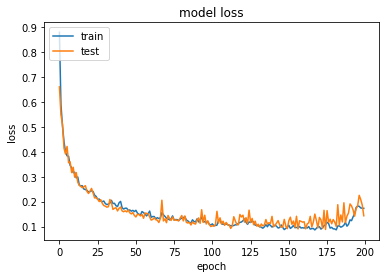

In [13]:
plt.plot(histories[9].history['loss'])
plt.plot(histories[9].history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Сравнение предсказанных значений истинным 

<Figure size 1440x360 with 0 Axes>

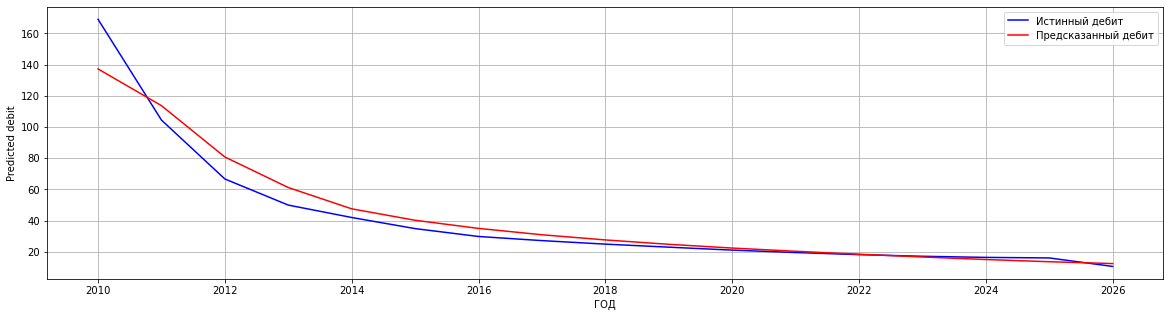

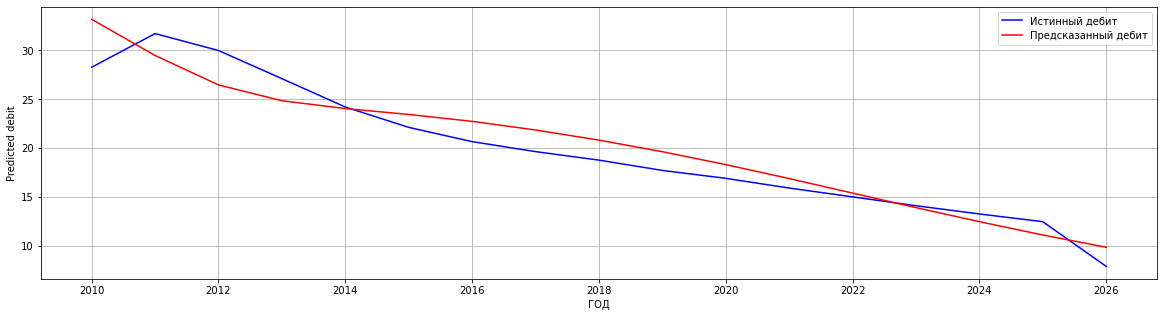

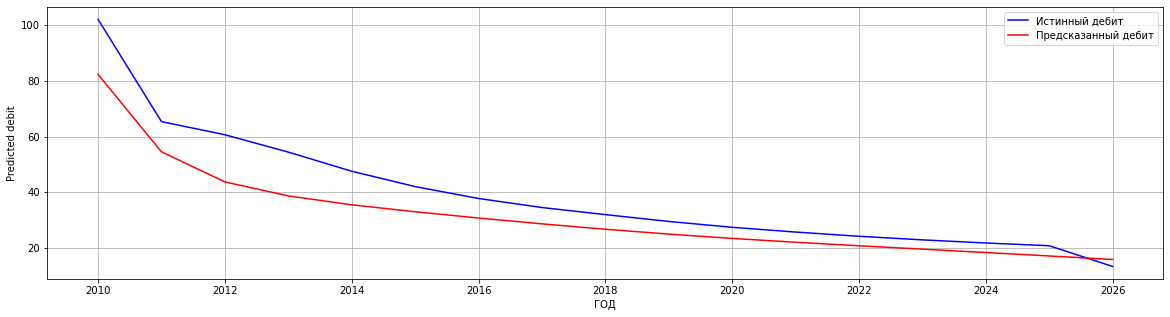

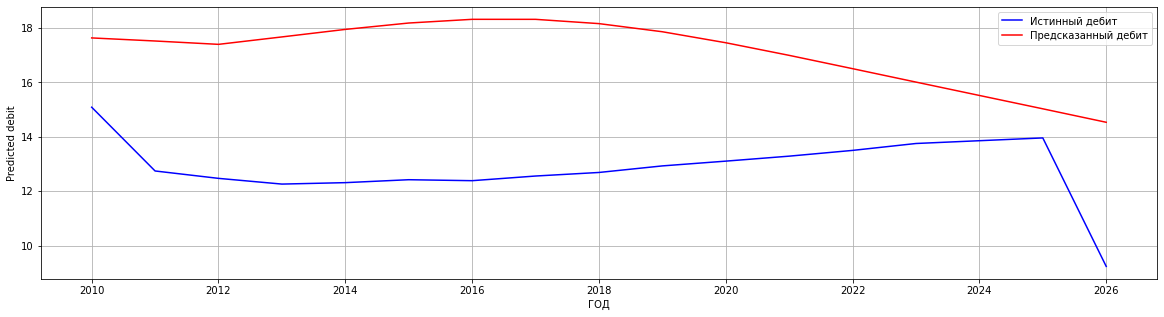

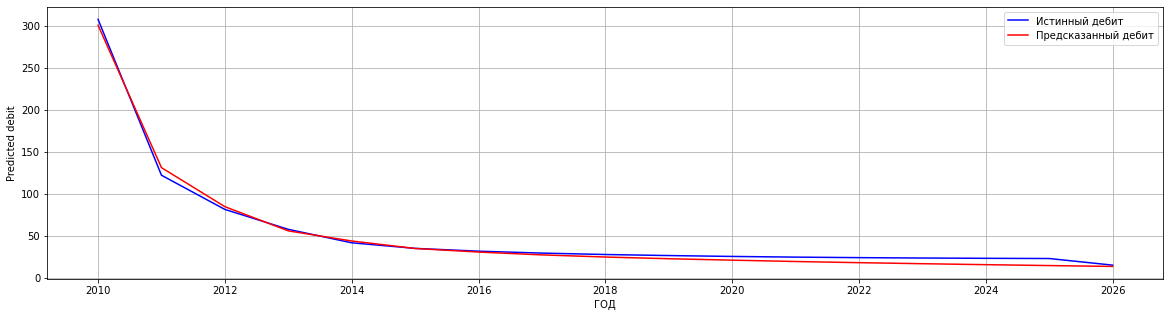

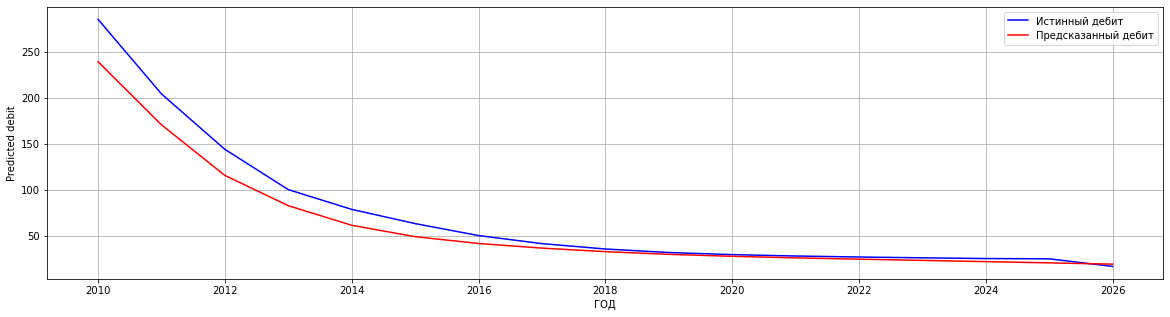

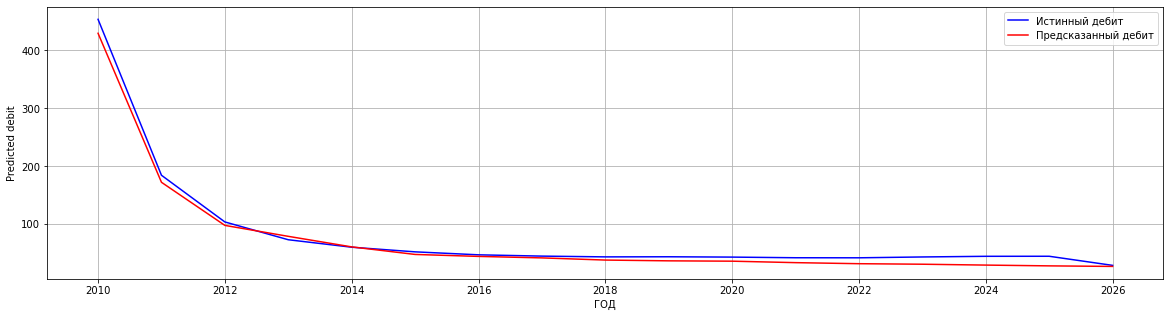

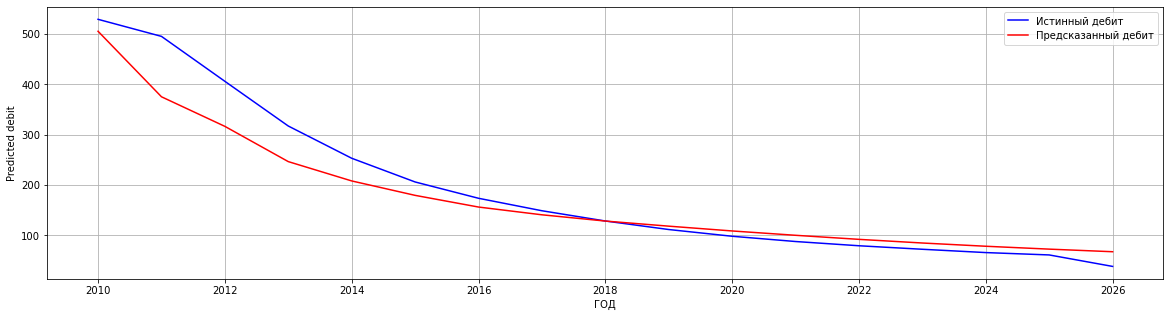

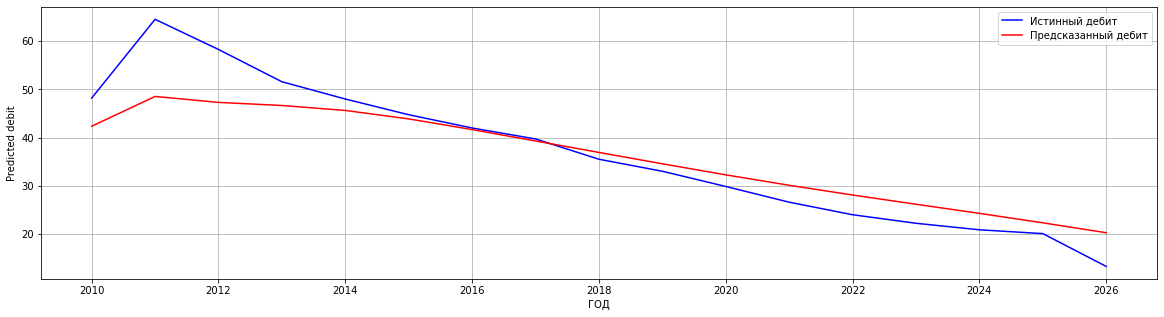

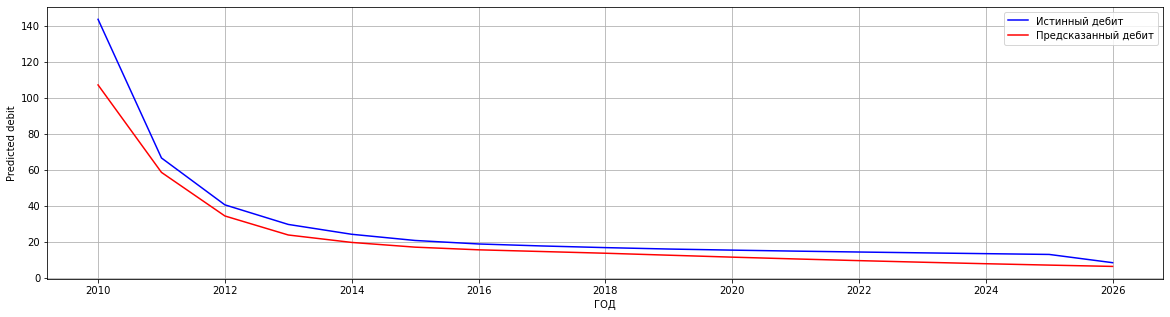

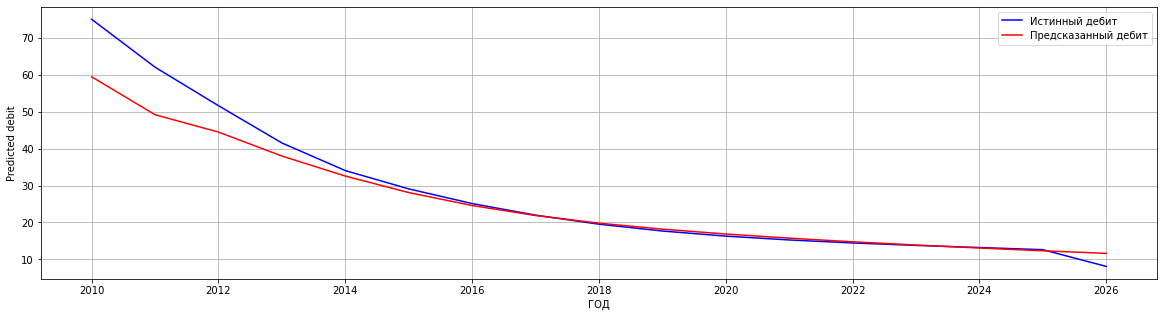

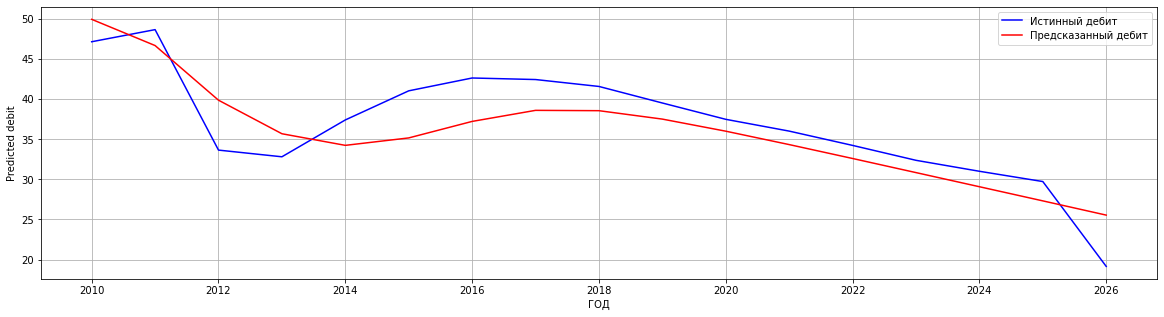

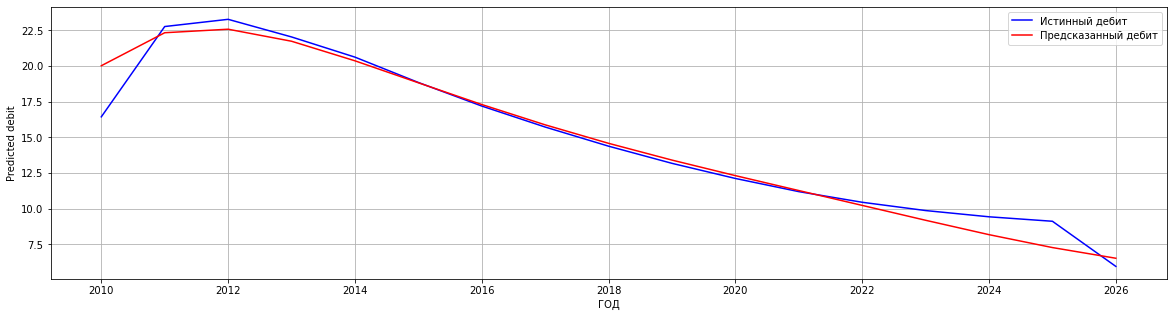

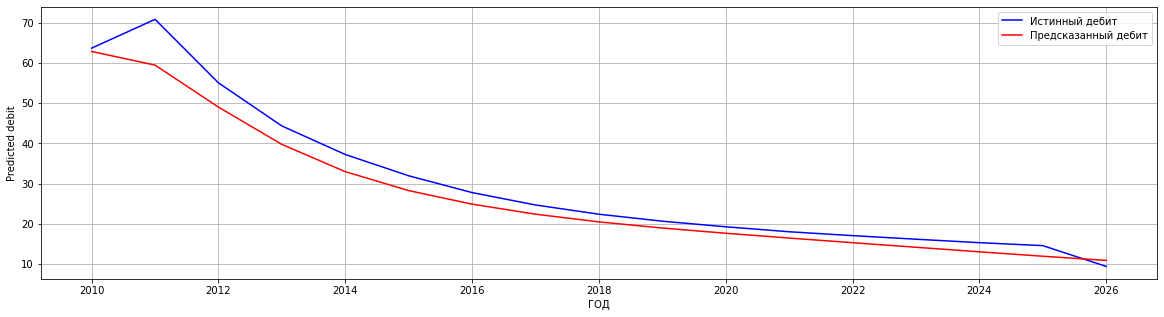

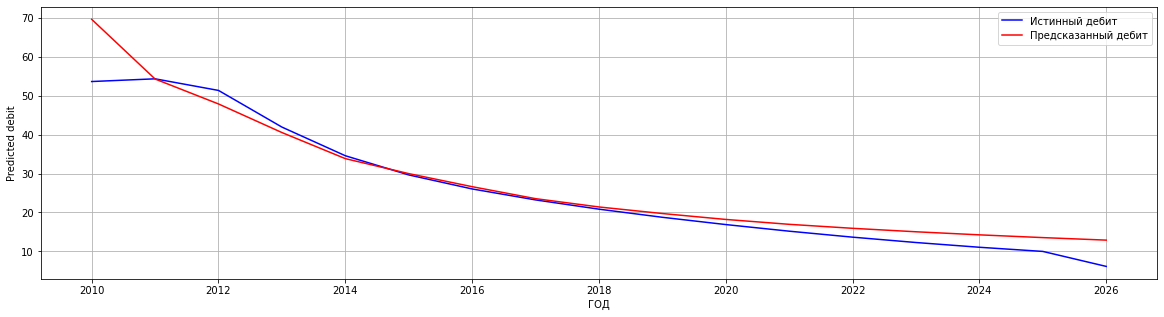

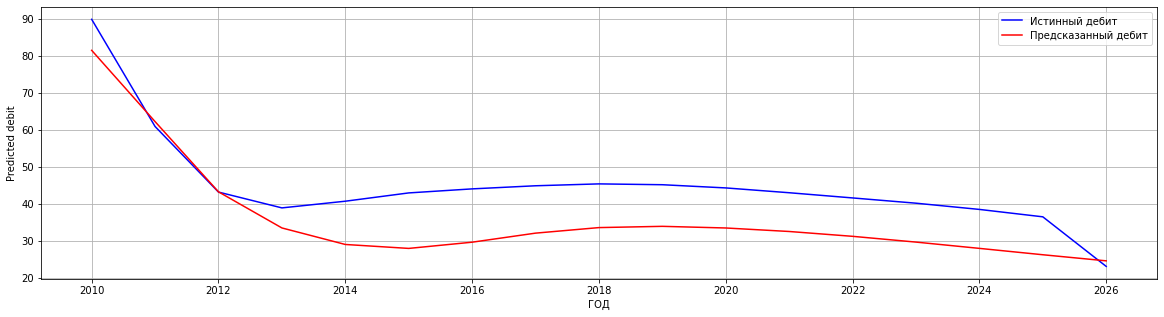

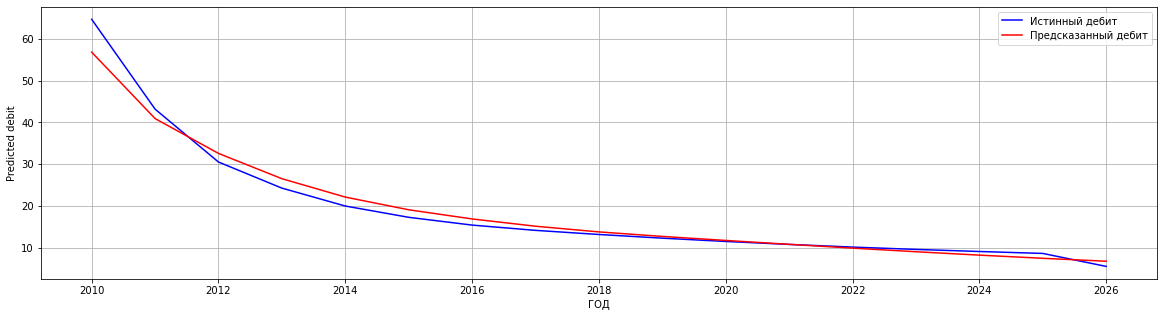

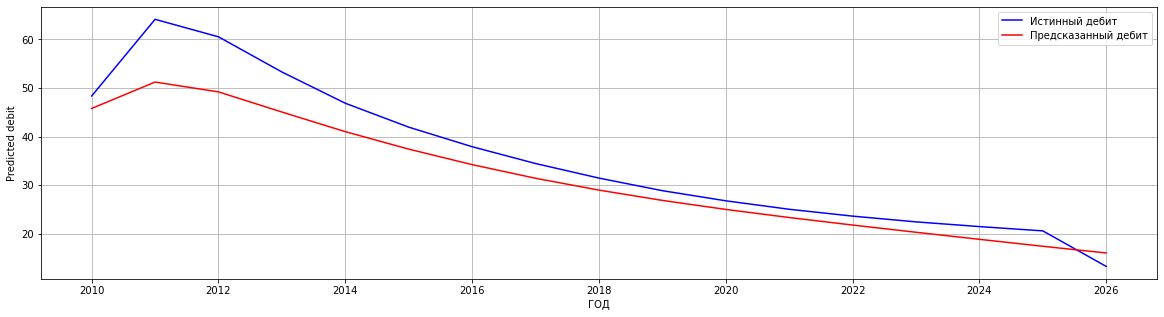

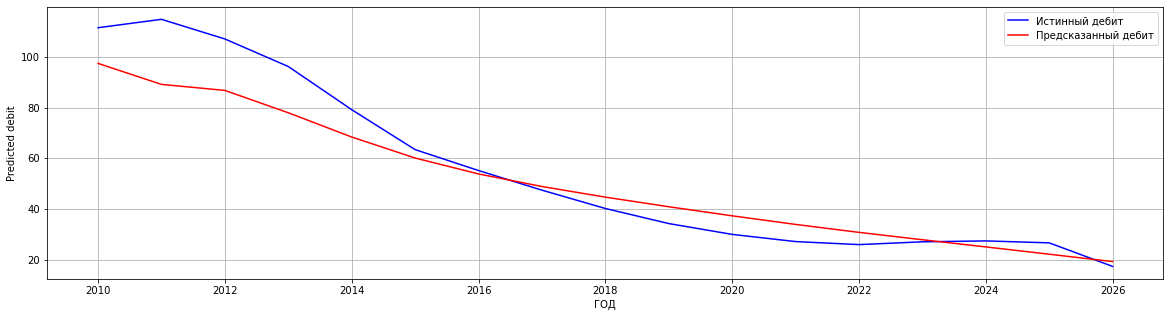

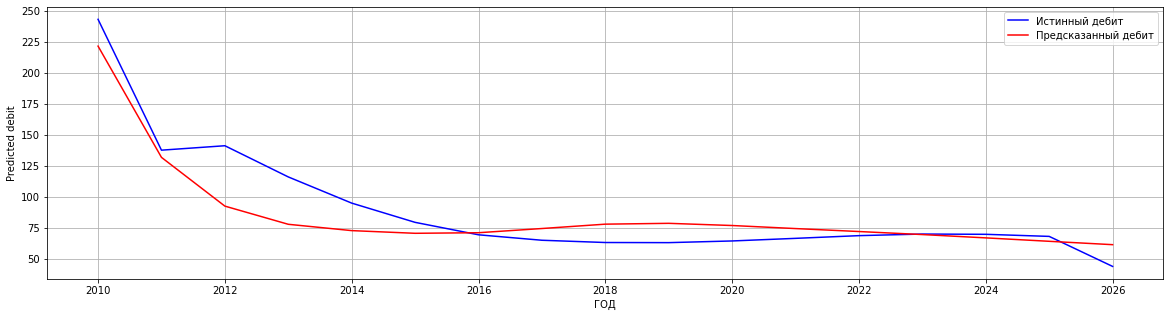

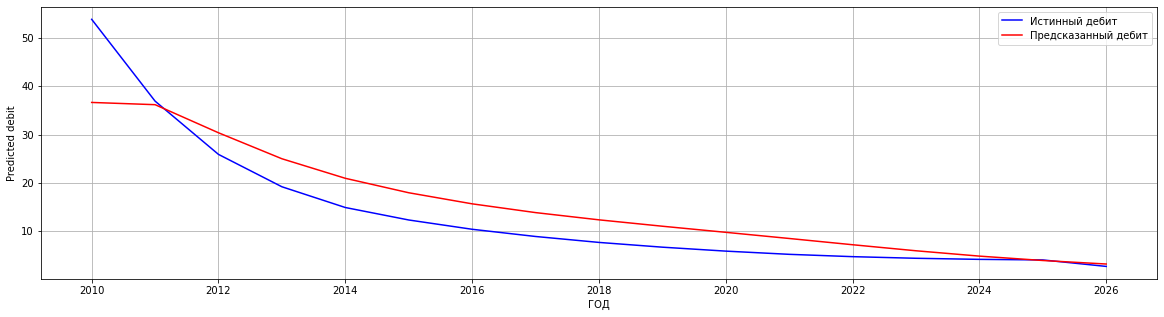

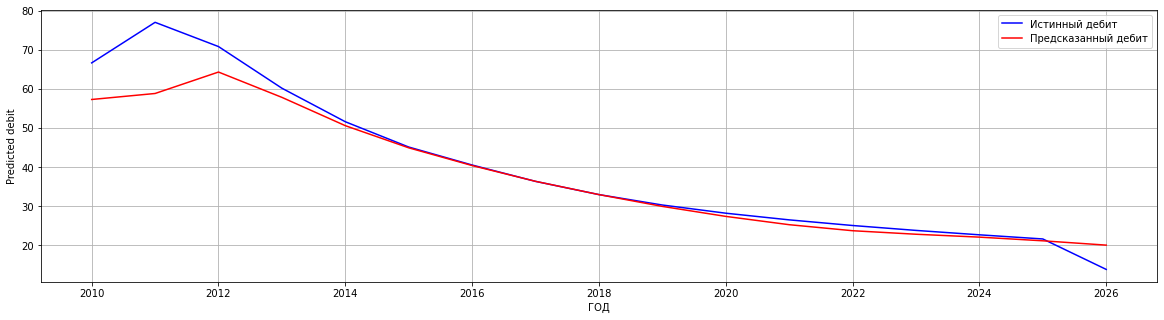

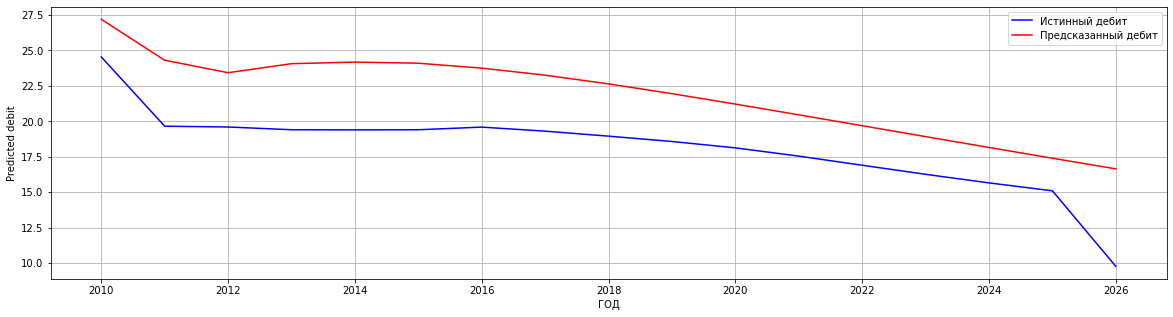

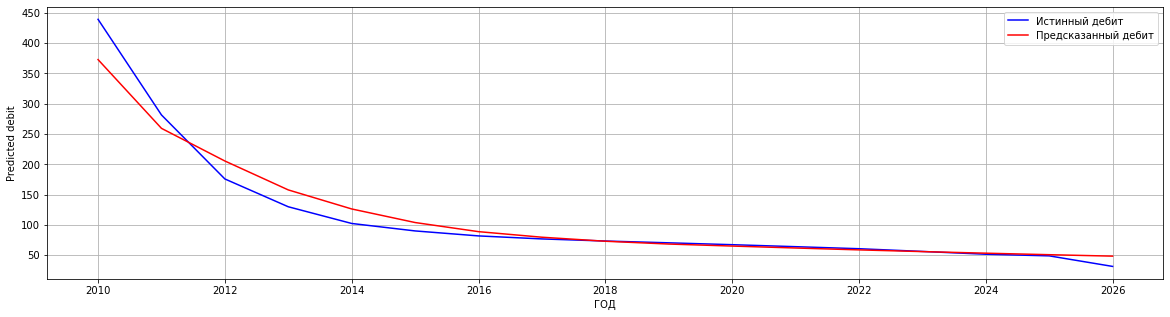

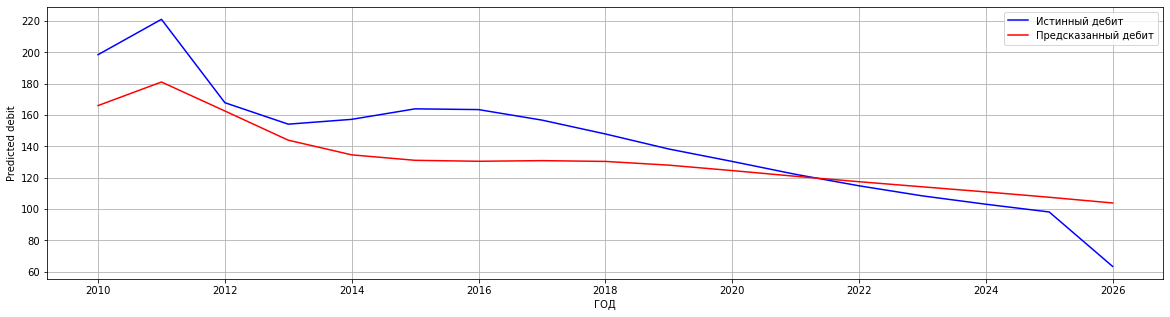

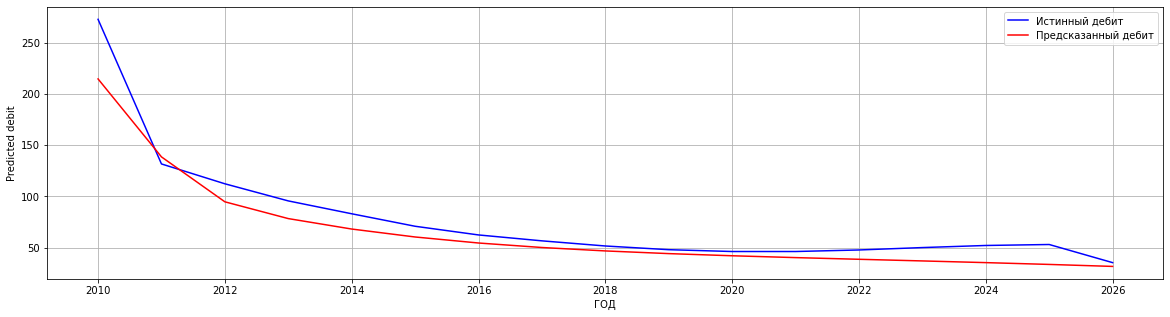

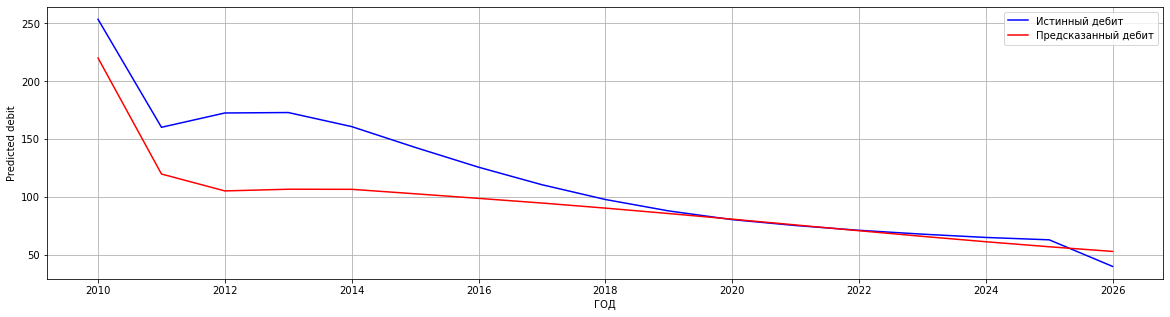

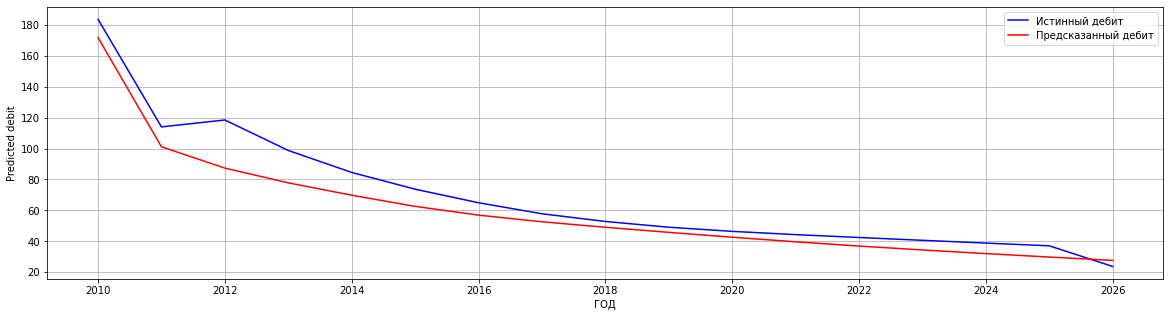

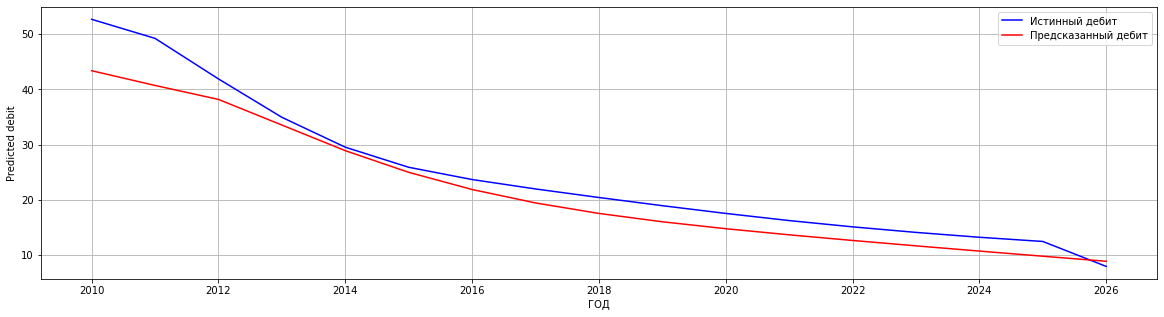

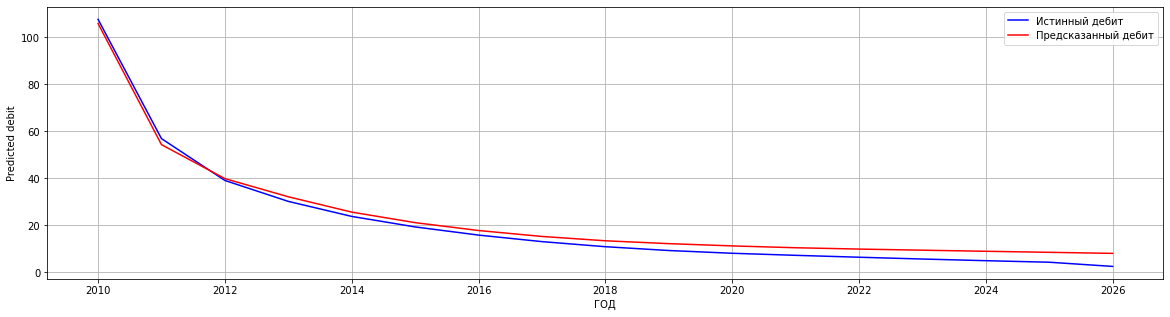

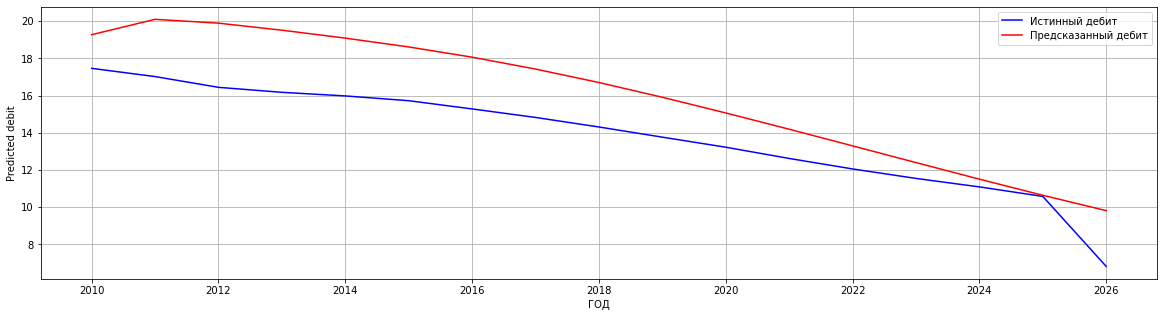

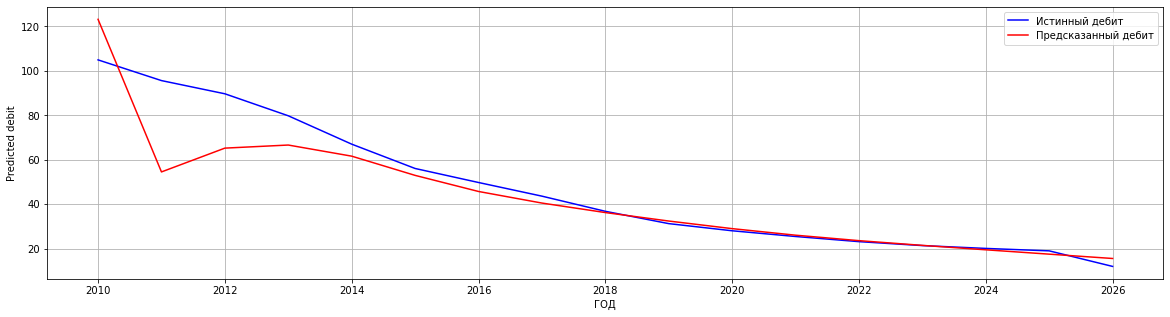

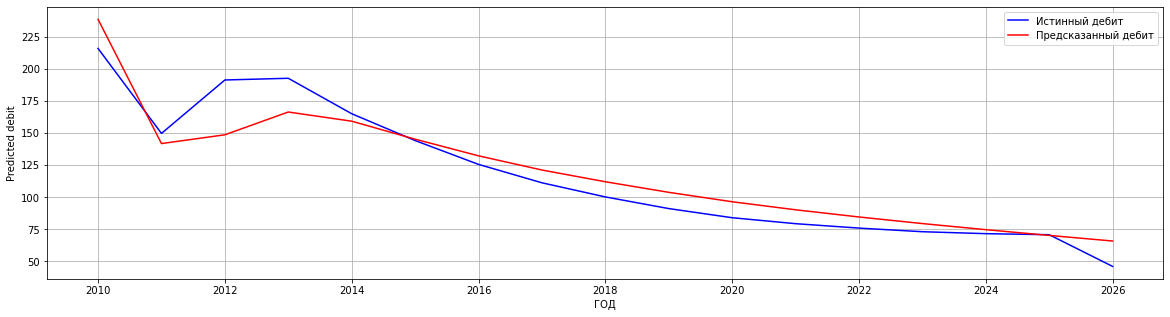

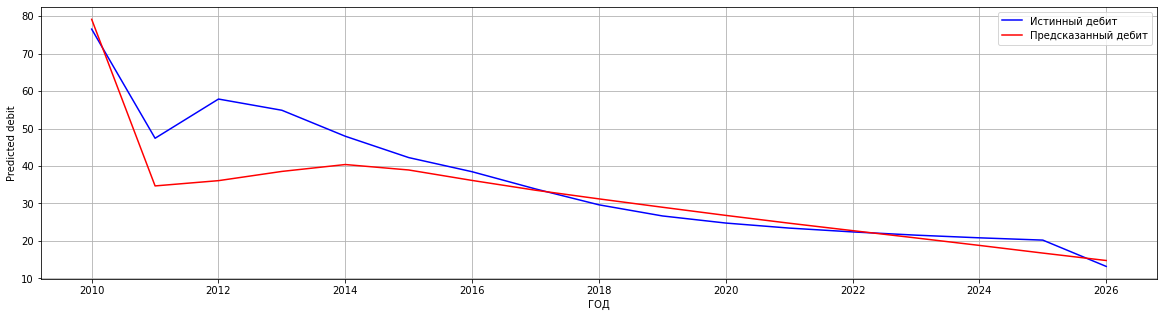

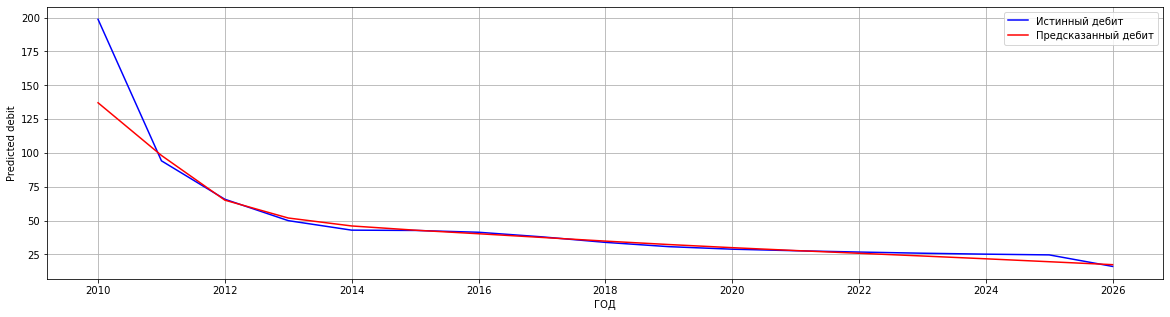

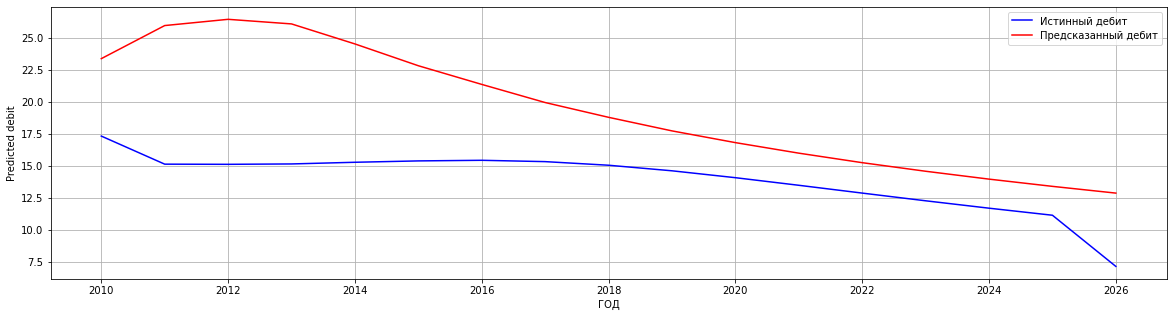

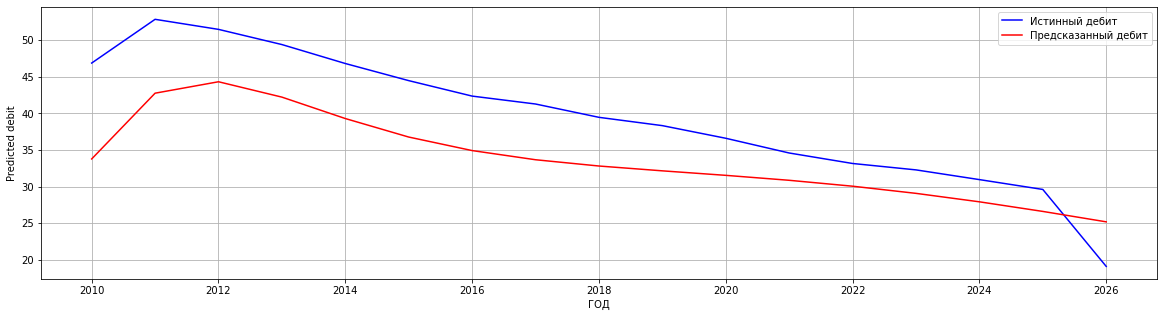

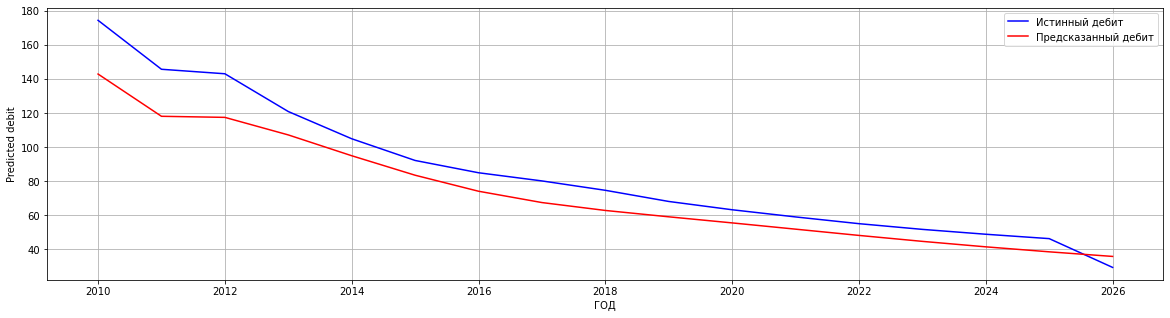

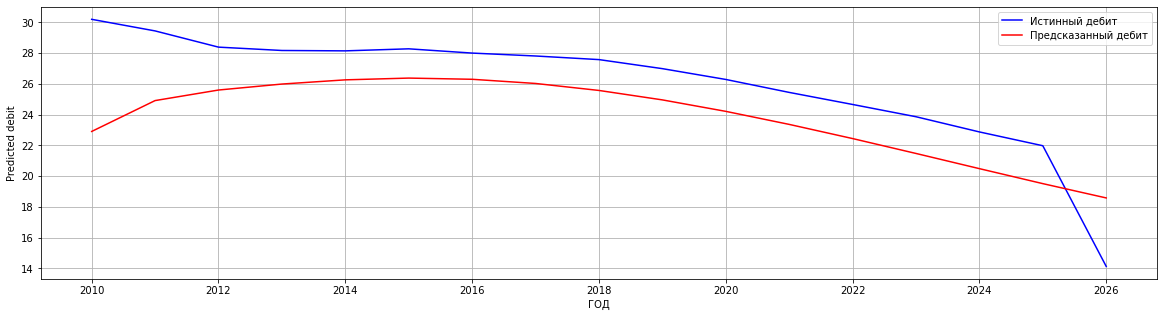

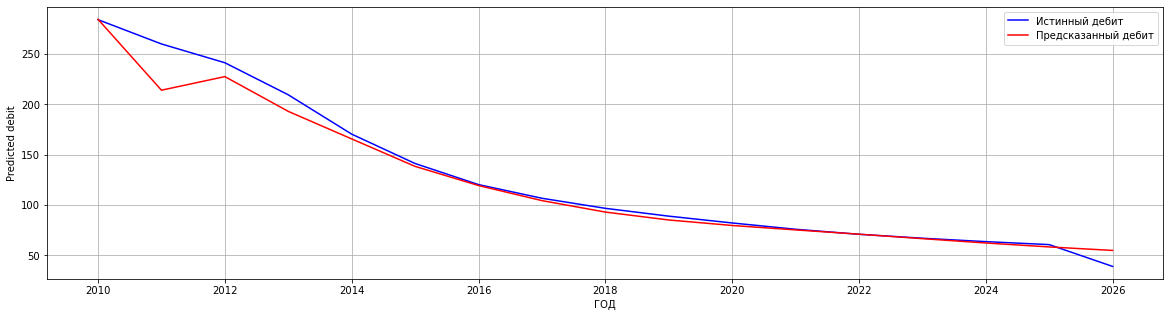

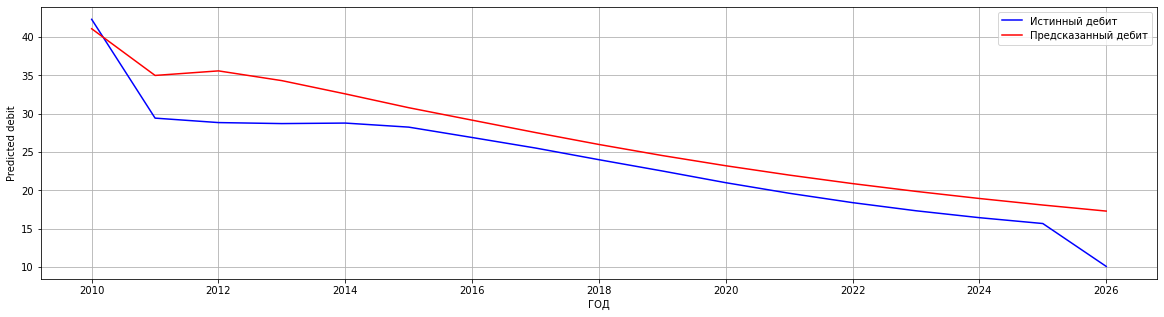

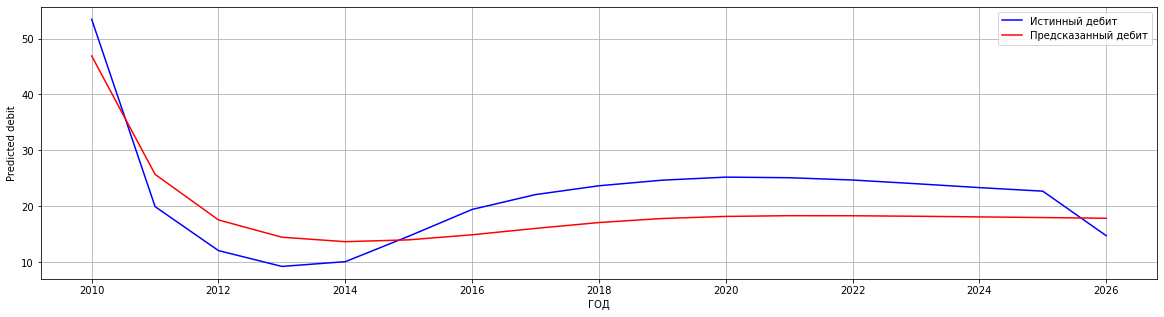

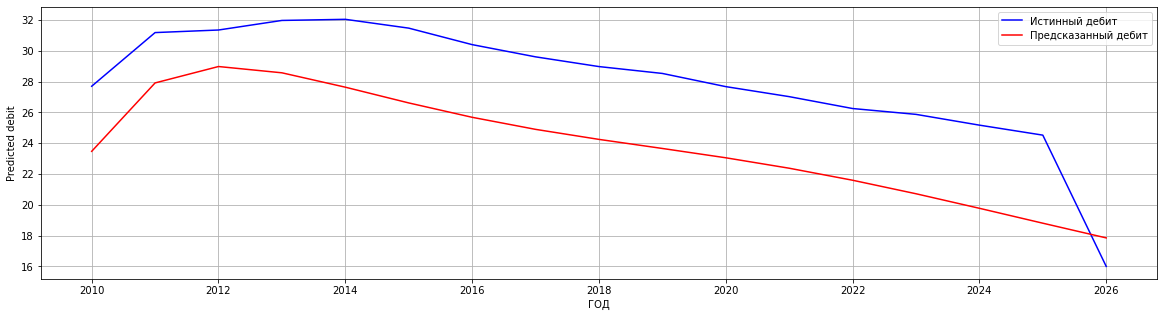

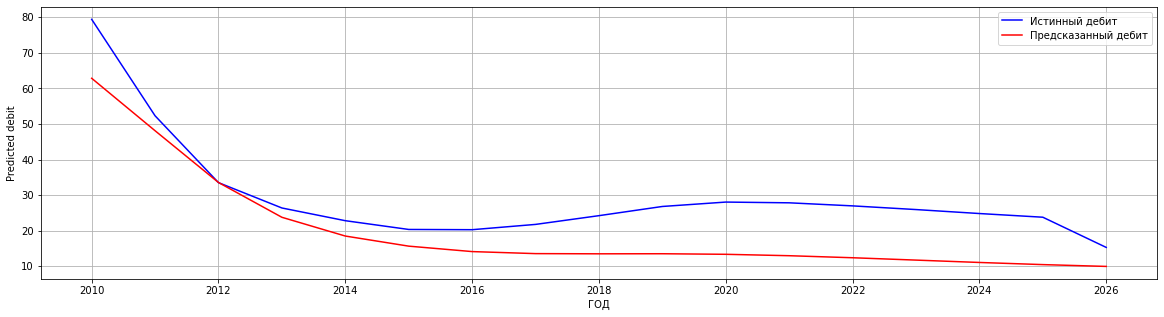

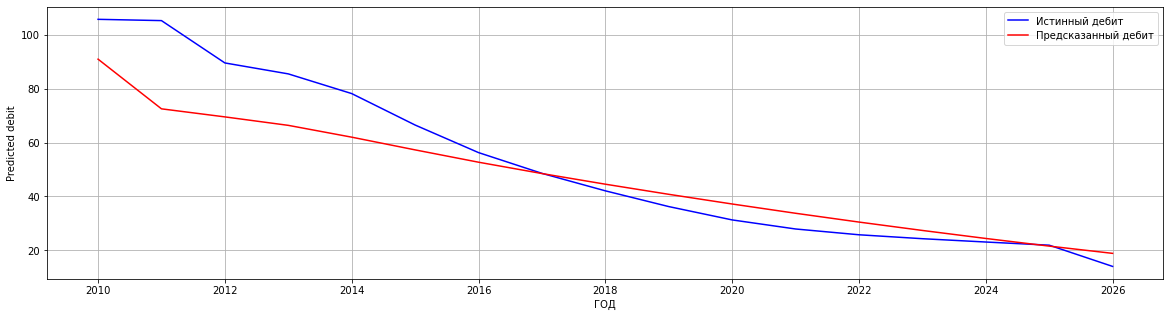

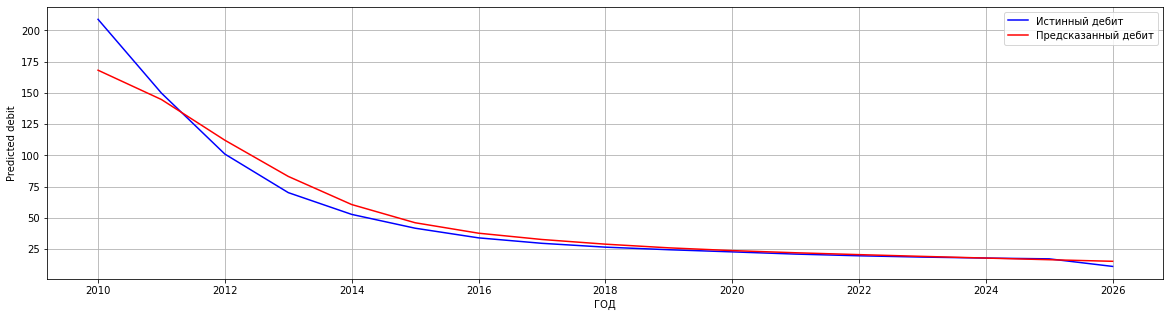

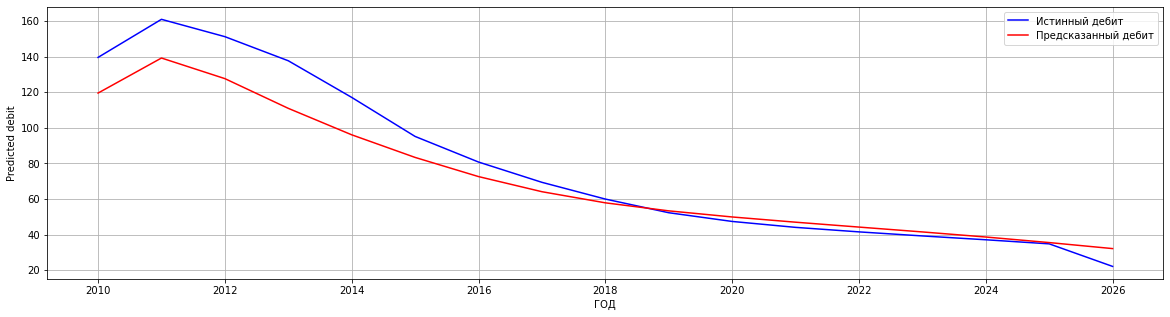

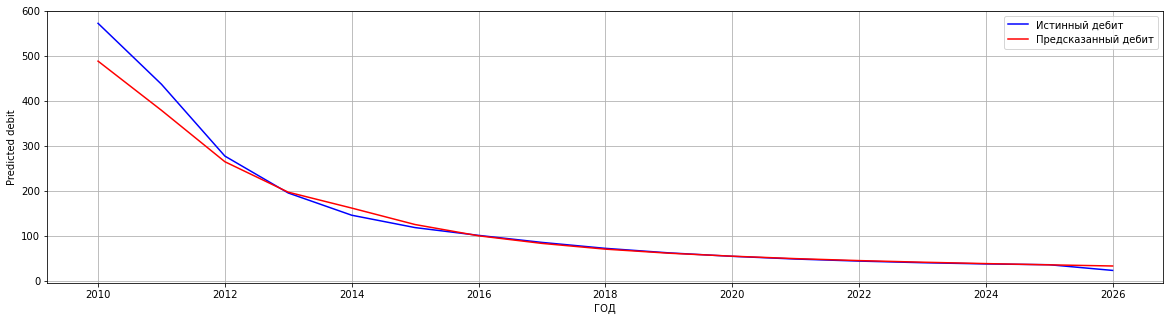

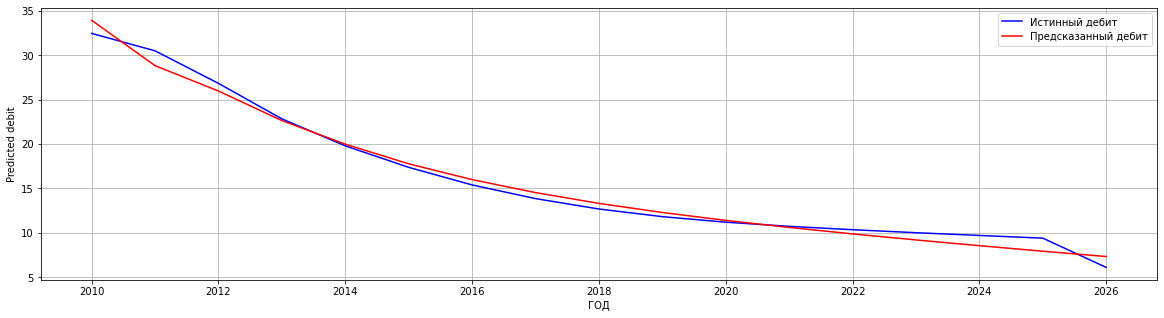

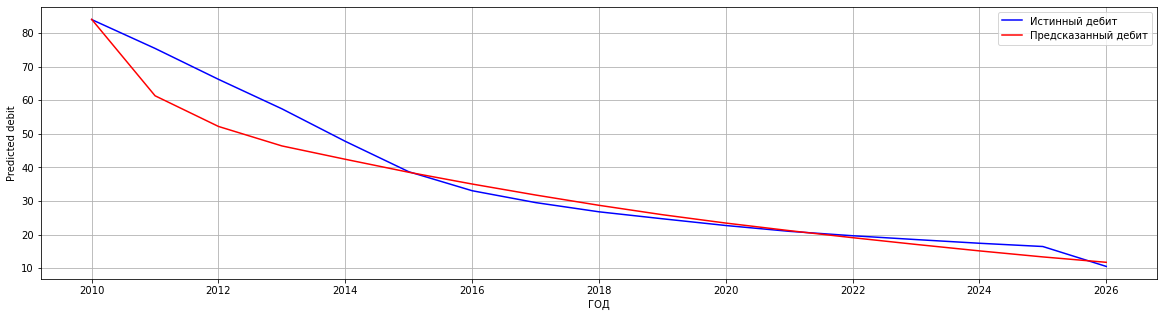

In [14]:
yy = test_y_transformed[:50] * scaler_y
pp = model.predict(test_x_transformed[:50]).reshape(test_y_transformed[:50].shape)

pp = pp*scaler_y
plt.figure(figsize=(20, 5))

for idx, i in enumerate(zip(yy.iterrows(), pp)):
    plt.figure(figsize=(20, 5))

    plt.plot(np.arange(n_timesteps)+2010, i[0][1], 'b', label='Истинный дебит')
    a = i[1]
    
    plt.plot(np.arange(n_timesteps)+2010, a, 'r', label='Предсказанный дебит')
    plt.legend()
    plt.xlabel('ГОД')
    plt.ylabel('Predicted debit')
    plt.grid()
    plt.show()

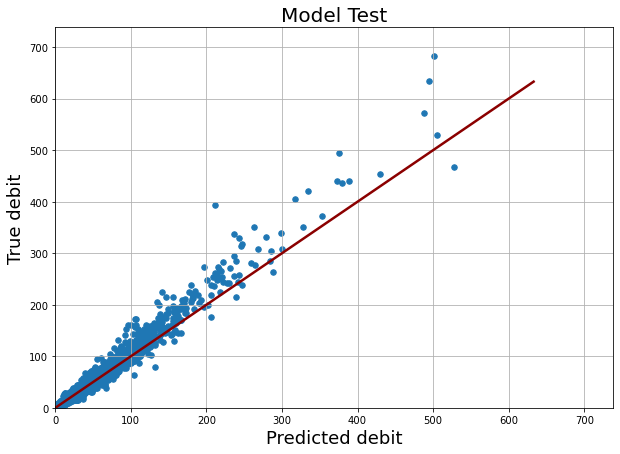

In [15]:
y_p = test_y_transformed * scaler_y
p_y = model.predict(test_x_transformed).reshape(test_y_transformed.shape)
p_y=p_y*scaler_y
xlabel = p_y
ylabel = y_p
plt.figure(figsize=(10,7))

plt.scatter(xlabel, ylabel,s=30,zorder=1)
plt.title(f'Model Test',fontsize=20)
plt.ylabel('True debit',fontsize=18)
plt.xlabel('Predicted debit',fontsize=18)

xmp2 = [0,xlabel.max()*1.2]
ymp2 = [0,xlabel.max()*1.2]

plt.plot(xmp2, ymp2, label = "line 2",c='darkred',linewidth=2.5,zorder=2)
plt.ylim(0,xlabel.max()*1.4)
plt.xlim(0,xlabel.max()*1.4)
plt.grid()
plt.show()

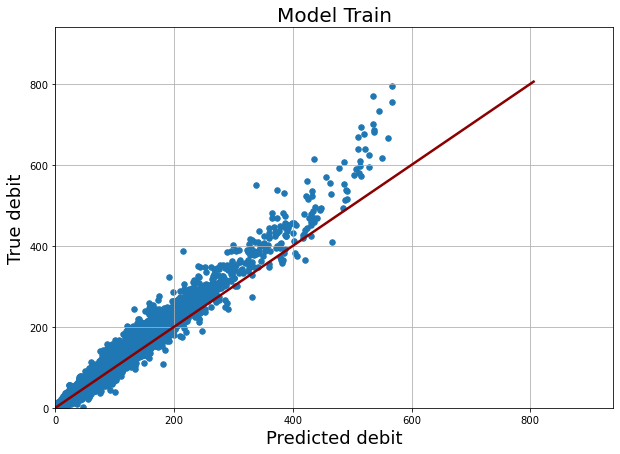

In [16]:
y_p = train_y_transformed * scaler_y
p_y = model.predict(train_x_transformed).reshape(train_y_transformed.shape)
p_y=p_y*scaler_y
xlabel = p_y
ylabel = y_p
plt.figure(figsize=(10,7))

plt.scatter(xlabel, ylabel,s=30,zorder=1)
plt.title(f'Model Train',fontsize=20)
plt.ylabel('True debit',fontsize=18)
plt.xlabel('Predicted debit',fontsize=18)

xmp2 = [0,xlabel.max()*1.2]
ymp2 = [0,xlabel.max()*1.2]
# plotting the line 2 points 
plt.plot(xmp2, ymp2, label = "line 2",c='darkred',linewidth=2.5,zorder=2)
plt.ylim(0,xlabel.max()*1.4)
plt.xlim(0,xlabel.max()*1.4)
plt.grid()
plt.show()

In [17]:
X_transformed=scaler_X.fit_transform(np.array(X))
pred_all =  model.predict(X_transformed)
pred_all = pred_all * scaler_y
pred_all[pred_all < 0] = 0 
p_y_=pd.DataFrame({'debit_summ':Y.sum(axis=1)})
p_y_['predicted'] = pred_all.sum(axis=1)
print(len(p_y_))
print(len(X))
ranged = p_y_.iloc[np.argsort(p_y_.debit_summ.values)[::-1]]
ranged.index = list(range(len(ranged)))

ranged.loc[np.argsort(ranged.predicted.values)[::-1] , 'place_ml'] = list(range(len(ranged)))
ranged['place_ml'] = ranged['place_ml'].astype('int64')
ranged[0:10]

1478
1478


,debit_summ,predicted,place_ml
0,3810.275864,2856.936279,4
1,3682.925773,2904.816162,3
2,3510.132787,3019.693604,1
3,3324.266232,2628.070312,14
4,3322.636049,2731.246582,8
5,3272.103526,2978.948730,2
6,3255.472605,3144.968506,0
7,3252.159600,2603.178223,15
8,3230.370258,2760.041260,7
9,3066.018461,2727.626709,9
